# GSE75688

In [ ]:
import gzip
import pandas as pd

# Reading tsv.gz files using common functions
def read_tsv_gz(file_path):
    with gzip.open(file_path, 'rt') as f:  #'rt' mode reads text from compressed file
        df= pd.read_csv(f, sep='\t', header=None)  #tab-separated values
    return df

In [ ]:
pd.set_option('display.max_rows', None)  # None means no limit
pd.set_option('display.max_columns', None)

# Prevent truncation of cell content
pd.set_option('display.max_colwidth', None)

### Preprocessing the Data

In [9]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt


In [8]:
import gzip
from scipy.io import mmread
import pandas as pd

# Function to read .mtx.gz file 
def read_mtx_gz(file_path):
    with gzip.open(file_path, 'rb') as f:  # 'rb' mode reads binary from compressed file
        matrix = mmread(f)  # this is a sparse matrix

    #sparse matrix to a data frame
    df = pd.DataFrame(matrix.toarray())  
    df= df.T #cells x genes format 
    return df

In [ ]:
file_path1 = 'GSE75688_final_sample_information.txt.gz'
metadata = pd.read_csv(file_path1, sep='\t')

In [ ]:
sc.settings.verbosity = 3

In [ ]:
metadata

In [ ]:
matrix= pd.read_csv("GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz", sep="\t")

In [ ]:
matrix

In [ ]:
matrix.columns.unique()

In [ ]:
gene_metadata = matrix[['gene_id', 'gene_name', 'gene_type']]
expression_data = matrix.drop(columns=['gene_id', 'gene_name', 'gene_type'])
expression_data = expression_data.T

In [ ]:
expression_data

In [ ]:
expression_data.columns=matrix['gene_name'].to_numpy()

In [ ]:
expression_data

In [ ]:
expression_data.index.name = 'cell_names'

In [ ]:
expression_data.columns.name='gene_names'

In [ ]:
expression_data

In [ ]:
adata = sc.AnnData(expression_data)

In [ ]:
adata.var_names_make_unique

In [ ]:
adata.var['gene_ids']= gene_metadata['gene_id'].values
adata.var['gene_type'] = gene_metadata['gene_type'].values

In [ ]:
adata

In [ ]:
adata.var

In [ ]:
adata.obs

In [ ]:
print(list(adata.obs_names))

In [ ]:
adata.obs_names

In [ ]:
metadata['sample']

In [ ]:
metadata

In [ ]:
adata.obs = adata.obs.join(metadata.set_index('sample'), on=adata.obs.index, how='left')

In [ ]:
adata.obs['key_0']

In [ ]:
adata.obs

In [ ]:
adata.obs['index2'].unique()

In [ ]:
adata.obs['index3'].unique()

In [ ]:
adata.obs['index'].unique()

In [ ]:
adata.obs=adata.obs.drop(columns=['index2'])

In [ ]:
adata.obs.rename(columns={'index3': 'Type of Cell'}, inplace=True)

In [ ]:
adata.obs.rename(columns={'index': 'Tumor/Non-Tumor'}, inplace=True)

In [ ]:
adata.obs=adata.obs.drop(columns=['key_0'])

In [ ]:
adata.obs['type'].value_counts()

In [ ]:
adata.obs['Tumor/Non-Tumor'].value_counts()

In [ ]:
adata.obs['Type of Cell'].value_counts()

### Quality Control

In [ ]:
adata.var["mt"] = adata.var_names.str.startswith("MT")

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [ ]:
adata_n= adata.copy()
sc.pp.calculate_qc_metrics(adata_n, qc_vars=["mt"],percent_top=None, log1p=False, inplace=True)

In [ ]:
adata_n.var

In [ ]:
adata_n.obs

In [ ]:
adata_n

In [ ]:
adata_n.var_names_make_unique()

In [ ]:
sc.pl.violin(adata_n, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata_n, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
import seaborn as sns
sns.jointplot(
    data=adata_n.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
)

In [ ]:
n_cells_by_counts = adata_n.var['n_cells_by_counts']
plt.figure(figsize=(10, 6))
sns.histplot(n_cells_by_counts, bins=100, kde=True)
plt.title('Distribution of n_cells_by_counts')
plt.xlabel('n_cells_by_counts')
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.DataFrame(adata_n.var.n_cells_by_counts<50).value_counts()

14000 genes expressed in less than 50 cells

In [ ]:
sc.pp.filter_cells(adata_n, min_genes=100)

In [ ]:
sc.pp.filter_genes(adata_n, min_cells=3)

remove doublets

In [ ]:
adata_n = adata_n[adata_n.obs.n_genes_by_counts < 18000, :]

remove cells with high MT content

In [ ]:
adata_n = adata_n[adata_n.obs.pct_counts_mt < 25, :]

In [ ]:
sc.pl.violin(adata_n, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

In [ ]:
adata_n

### Normalization

In [ ]:
normal_adata = adata_n.copy()

In [ ]:
sc.pp.normalize_total(normal_adata)
sc.pp.log1p(normal_adata)

### Highly Variable Genes

In [ ]:
hvg_adata = normal_adata.copy()

In [ ]:
sc.pp.highly_variable_genes(hvg_adata, n_top_genes=2000)

In [ ]:
sc.pl.highly_variable_genes(hvg_adata)

### PCA

In [ ]:
pca_adata = hvg_adata.copy()

In [ ]:
sc.tl.pca(pca_adata, n_comps=60)

In [ ]:
sc.pl.pca_loadings(pca_adata)

In [ ]:
sc.pl.pca_variance_ratio(pca_adata, n_pcs=100, log=True)

In [ ]:
sc.pl.pca(pca_adata, color="type")

In [ ]:
sc.pl.pca(pca_adata, color="Type of Cell")

In [ ]:
sc.pl.pca(pca_adata, color="Tumor/Non-Tumor")

### UMAP

In [ ]:
sc.pp.neighbors(pca_adata)

In [ ]:
sc.tl.umap(pca_adata)

In [ ]:
sc.pl.umap(pca_adata)

In [ ]:
sc.pl.umap(pca_adata, color="Tumor/Non-Tumor")

In [ ]:
sc.pl.umap(pca_adata, color="Type of Cell")

In [ ]:
sc.pl.umap(pca_adata, color="type")

In [ ]:
sc.pl.umap(pca_adata, color="TSPAN6")

### Clusters

In [ ]:
!pip3 install igraph

In [ ]:
pip install leidenalg

In [ ]:
sc.tl.leiden(pca_adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(pca_adata, key_added="leiden_res0_5", resolution=0.5)

In [ ]:
sc.pl.umap(pca_adata, color=["leiden_res0_25"])

In [ ]:
sc.pl.umap(pca_adata, color=["leiden_res0_5"])

In [ ]:
sc.tl.leiden(pca_adata, key_added="leiden_res7_5", resolution=0.75)

In [ ]:
sc.pl.umap(pca_adata, color=["leiden_res7_5"])

In [ ]:
sc.tl.leiden(pca_adata, key_added="leiden_res1", resolution=1)

In [ ]:
sc.pl.umap(pca_adata, color=["leiden_res1", "leiden_res0_5", "leiden_res0_25"])

### Marker Genes

In [ ]:
sc.tl.rank_genes_groups(pca_adata, "leiden_res0_5", method="wilcoxon")
sc.pl.rank_genes_groups(pca_adata, n_genes=25)

In [ ]:
pca_adata.uns["rank_genes_groups"]

# GSE161529

In [ ]:
Downloads/GSE161529_RAW

In [ ]:
barcode_dfs

In [ ]:
(matrix_dfs)

In [7]:
import pandas as pd
from scipy.sparse import vstack, save_npz, load_npz
import os
import gc
import scanpy as sc
import numpy as np

In [9]:
matrix_file = "final_combined_matrix.npz"

In [10]:
final_matrix = load_npz(matrix_file)

# Example: Display the shape of the matrix
print(f"Shape of the combined matrix: {final_matrix.shape}")

Shape of the combined matrix: (428024, 33538)


In [31]:
import os
import pandas as pd
from scipy.sparse import vstack, csr_matrix
import gzip
from scipy.io import mmread



# Function to read .tsv.gz file
def read_tsv_gz(file_path):
    with gzip.open(file_path, 'rt') as f:  # 'rt' mode reads text from compressed file
        df = pd.read_csv(f, sep='\t', header=None)  # Tab-separated values
    return df


data_folder = "E:/GSE161529_RAW" # Folder containing gzipped files
features_path = "E:/GSE161529_features.tsv"  # Path to features.tsv file

def load_data(data_folder):
    barcode_dfs = []


    for file in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file)

        if file.endswith("barcodes.tsv.gz"):
            print(f"Reading {file}...")
            barcode_dfs.append(read_tsv_gz(file_path))  # Append barcodes DataFrame
  
    
    return barcode_dfs

barcode_dfs = load_data(data_folder)



Reading GSM4909253_N-PM0092-Total-barcodes.tsv.gz...
Reading GSM4909254_N-PM0019-Total-barcodes.tsv.gz...
Reading GSM4909255_N-N280-Epi-barcodes.tsv.gz...
Reading GSM4909256_N-PM0095-Epi-barcodes.tsv.gz...
Reading GSM4909257_N-PM0095-Total-barcodes.tsv.gz...
Reading GSM4909258_N-NF-Epi-barcodes.tsv.gz...
Reading GSM4909259_N-NE-Epi-barcodes.tsv.gz...
Reading GSM4909260_N-N1105-Epi-barcodes.tsv.gz...
Reading GSM4909261_N-PM0230-Total-barcodes.tsv.gz...
Reading GSM4909262_N-MH0064-Epi-barcodes.tsv.gz...
Reading GSM4909263_N-MH0064-Total-barcodes.tsv.gz...
Reading GSM4909264_N-N1B-Epi-barcodes.tsv.gz...
Reading GSM4909265_N-PM0233-Total-barcodes.tsv.gz...
Reading GSM4909266_N-MH0169-Total-barcodes.tsv.gz...
Reading GSM4909267_N-MH0023-Epi-barcodes.tsv.gz...
Reading GSM4909268_N-MH0023-Total-barcodes.tsv.gz...
Reading GSM4909269_N-PM0342-Epi-barcodes.tsv.gz...
Reading GSM4909270_N-PM0342-Total-barcodes.tsv.gz...
Reading GSM4909271_N-MH288-Total-barcodes.tsv.gz...
Reading GSM4909272_N-MH002

In [84]:

barcodes_combined = pd.concat(barcode_dfs, axis=0, ignore_index=True)

In [5]:
barcodes_combined.to_csv("barcodes.csv", index=False, header=False)

In [85]:
barcodes_combined.shape

(428024, 1)

In [ ]:
df.dtypes

In [11]:
final_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 616564860 stored elements and shape (428024, 33538)>

In [11]:
chunk_df=pd.DataFrame()

In [10]:
import pandas as pd
from scipy.sparse import load_npz

def sparse_matrix_to_csv(sparse_matrix, output_file, chunk_size=100):
    """
    Convert a sparse matrix to a CSV file in batches.

    Parameters:
        sparse_matrix (scipy.sparse.spmatrix): Input sparse matrix.
        output_file (str): Path to the output CSV file.
        chunk_size (int): Number of rows to process in each batch.
    """
    rows, cols = sparse_matrix.shape
    print(f"Converting a sparse matrix of shape {rows}x{cols} to a CSV in batches of {chunk_size} rows...")

    with open(output_file, 'w') as f:
        for i in range(0, rows, chunk_size):
            print(f"Processing rows {i} to {min(i + chunk_size, rows)}...")
            chunk = sparse_matrix[i:i + chunk_size, :].toarray()
            chunk_df = pd.DataFrame(chunk)
            chunk_df.to_csv(f, mode='a', index=False, header=(i == 0)) 
    print(f"Data saved to '{output_file}'.")


# Convert to CSV in chunks
sparse_matrix_to_csv(final_matrix, "df.csv", chunk_size=1000)


Converting a sparse matrix of shape 428024x33538 to a CSV in batches of 1000 rows...
Processing rows 0 to 1000...
Processing rows 1000 to 2000...
Processing rows 2000 to 3000...
Processing rows 3000 to 4000...
Processing rows 4000 to 5000...
Processing rows 5000 to 6000...
Processing rows 6000 to 7000...
Processing rows 7000 to 8000...
Processing rows 8000 to 9000...
Processing rows 9000 to 10000...
Processing rows 10000 to 11000...
Processing rows 11000 to 12000...
Processing rows 12000 to 13000...
Processing rows 13000 to 14000...
Processing rows 14000 to 15000...
Processing rows 15000 to 16000...
Processing rows 16000 to 17000...
Processing rows 17000 to 18000...
Processing rows 18000 to 19000...
Processing rows 19000 to 20000...
Processing rows 20000 to 21000...
Processing rows 21000 to 22000...
Processing rows 22000 to 23000...
Processing rows 23000 to 24000...
Processing rows 24000 to 25000...
Processing rows 25000 to 26000...
Processing rows 26000 to 27000...
Processing rows 270

In [12]:
import time

In [15]:
pip install dask

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
import dask.dataframe as dd
df = dd.read_csv("df.csv")  # Replace with appropriate format

print(df.head())

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   0  1  2  3  4  5  6  7  8  9  ...  33528  33529  33530  33531  33532  \
0  0  0  0  0  0  0  0  0  0  0  ...      0      0      1      0      0   
1  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
2  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
3  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
4  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   

   33533  33534  33535  33536  33537  
0      0      0      0      0      0  
1      0      0      0      0      0  
2      0      0      0      0      0  
3      0      0      0      0      0  
4      0      0      0      0      0  

[5 rows x 33538 columns]


In [12]:
adata = sc.AnnData(X=final_matrix)

In [18]:
adata

AnnData object with n_obs × n_vars = 428024 × 33538

In [20]:

import gc
gc.collect()

0

In [87]:
features=pd.read_csv("E:/GSE161529_features.tsv/features.tsv", header=None, sep="\t")

In [88]:
features

,0,1,2
0,ENSG00000243485,MIR1302-2HG,Gene Expression
1,ENSG00000237613,FAM138A,Gene Expression
2,ENSG00000186092,OR4F5,Gene Expression
3,ENSG00000238009,AL627309.1,Gene Expression
4,ENSG00000239945,AL627309.3,Gene Expression
...,...,...,...
33533,ENSG00000277856,AC233755.2,Gene Expression
33534,ENSG00000275063,AC233755.1,Gene Expression
33535,ENSG00000271254,AC240274.1,Gene Expression
33536,ENSG00000277475,AC213203.1,Gene Expression


In [23]:
features[2].value_counts()

2
Gene Expression    33538
Name: count, dtype: int64

In [24]:
adata.var.index= features[1].to_numpy()

In [25]:
adata.var.index.name= "gene_name"

In [26]:
adata.var

""
gene_name
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC233755.2
AC233755.1
AC240274.1


In [27]:
adata.var["gene_ids"]= features[0].to_numpy()

In [28]:
adata.var

,gene_ids
gene_name,
MIR1302-2HG,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
AL627309.1,ENSG00000238009
AL627309.3,ENSG00000239945
...,...
AC233755.2,ENSG00000277856
AC233755.1,ENSG00000275063
AC240274.1,ENSG00000271254


In [29]:
barcodes_combined

,0
0,AAACCTGAGACTAGGC-1
1,AAACCTGAGGACAGAA-1
2,AAACCTGAGGATGTAT-1
3,AAACCTGCAAGAGGCT-1
4,AAACCTGGTAGCTTGT-1
...,...
428019,TTTGTCACATCGATTG-1
428020,TTTGTCACATGTTCCC-1
428021,TTTGTCAGTAATTGGA-1
428022,TTTGTCATCATGTCCC-1


In [30]:
adata.obs.index=barcodes_combined[0].to_numpy()

In [31]:
adata.obs

""
AAACCTGAGACTAGGC-1
AAACCTGAGGACAGAA-1
AAACCTGAGGATGTAT-1
AAACCTGCAAGAGGCT-1
AAACCTGGTAGCTTGT-1
...
TTTGTCACATCGATTG-1
TTTGTCACATGTTCCC-1
TTTGTCAGTAATTGGA-1
TTTGTCATCATGTCCC-1


In [32]:
adata.obs.index.name="cell_barcode"

In [33]:
adata.obs

""
cell_barcode
AAACCTGAGACTAGGC-1
AAACCTGAGGACAGAA-1
AAACCTGAGGATGTAT-1
AAACCTGCAAGAGGCT-1
AAACCTGGTAGCTTGT-1
...
TTTGTCACATCGATTG-1
TTTGTCACATGTTCCC-1
TTTGTCAGTAATTGGA-1


In [34]:
adata

AnnData object with n_obs × n_vars = 428024 × 33538
    var: 'gene_ids'

In [35]:
import scipy.sparse as sp

In [36]:
adata.X = sp.csr_matrix(adata.X)

In [37]:
adata

AnnData object with n_obs × n_vars = 428024 × 33538
    var: 'gene_ids'

In [39]:
del features

In [40]:
del barcodes_combined

In [43]:
gc.collect()

0

In [38]:
adata.var["mt"] = np.char.startswith(adata.var_names.values.astype(str), "MT")

In [58]:
chunk_size = 100000
chunks = [
    adata[start:start + chunk_size] 
    for start in range(0, adata.n_obs, chunk_size)
]

In [59]:
processed_chunks = []
for chunk in chunks:
    # Quality control metrics
    sc.pp.calculate_qc_metrics(chunk, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    
    # Filter cells and genes in each chunk
    sc.pp.filter_cells(chunk, min_genes=100)
    sc.pp.filter_genes(chunk, min_cells=3)
    
    # Filter cells with high MT content and possible doublets
    chunk = chunk[chunk.obs.n_genes_by_counts < 18000, :]
    chunk = chunk[chunk.obs.pct_counts_mt < 25, :]
    
    # Normalize and log-transform
    sc.pp.normalize_total(chunk)
    sc.pp.log1p(chunk)
    
    # Append processed chunk
    processed_chunks.append(chunk)

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  util

In [65]:
gc.collect()

0

In [66]:
del chunks

In [67]:
gc.collect()

0

In [61]:
(processed_chunks)

[AnnData object with n_obs × n_vars = 93785 × 26457
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
     var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
     uns: 'log1p',
 AnnData object with n_obs × n_vars = 93477 × 26999
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
     var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
     uns: 'log1p',
 AnnData object with n_obs × n_vars = 95458 × 26557
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
     var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
     uns: 'log1p',
 AnnData object with n_obs × n_vars = 91449 × 26010
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
     var: 'gene_id

In [62]:
adata.write("adata.h5ad")

In [63]:
del adata

In [68]:
gc.collect()

0

In [71]:
for a in processed_chunks:
    a.var_names_make_unique()

In [75]:
import anndata as ad

In [73]:
del adata_processed

NameError: name 'adata_processed' is not defined

In [80]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.io import mmread
from scipy.sparse import csr_matrix


data_folder = "E:/GSE161529_RAW"  # Folder containing barcodes and matrix files
features_path = "E:/GSE161529_features.tsv/features.tsv"  # Path to features.tsv file
output_folder = "E:/GSE161529_organized" 


if not os.path.exists(output_folder):
    os.makedirs(output_folder)


features = pd.read_csv(features_path, sep="\t", header=None)
features.columns = ["gene_id", "gene_name", "feature_type"]


def process_sample(barcodes_path, matrix_path, sample_name):
    print(f"Processing sample: {sample_name}")
    barcodes = pd.read_csv(barcodes_path, header=None)
    matrix = mmread(matrix_path)
    matrix = csr_matrix(matrix)  

  
    adata = sc.AnnData(X=matrix)
    adata.obs_names = barcodes[0].values
    adata.var = features.set_index("gene_id")

    # Preprocessing
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.filter_cells(adata, min_genes=200)
    adata.var["mt"] = adata.var_names.str.startswith("MT-")  # Mark mitochondrial genes
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs["n_genes_by_counts"] < 2500, :]
    adata = adata[adata.obs["pct_counts_mt"] < 5, :]
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable]

    # PCA, UMAP, Leiden clustering
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=60)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5)

    # Add sample information
    adata.obs["sample"] = sample_name
    
    return adata


adata_list = []
for file in os.listdir(data_folder):
    if file.endswith("barcodes.tsv"):
        sample_name = file.split("_")[1]  # Extract sample name
        barcodes_path = os.path.join(data_folder, file)
        matrix_file = file.replace("barcodes.tsv", "matrix.mtx")
        matrix_path = os.path.join(data_folder, matrix_file)
        
        if os.path.exists(matrix_path):
        
            adata = process_sample(barcodes_path, matrix_path, sample_name)
            adata_list.append(adata)






In [12]:
barcodes_combined.rename(columns={'0': int('0')}, inplace=True)

In [ ]:

print("Integrating samples...")
adata_merged = sc.concat(adata_list, join="outer", label="sample", keys=None, index_unique="-")


sc.pp.scale(adata_merged, max_value=10)
sc.tl.pca(adata_merged, svd_solver="arpack")
sc.pp.neighbors(adata_merged, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata_merged)
sc.tl.leiden(adata_merged, resolution=0.5)


adata_merged.write_h5ad(os.path.join(output_folder, "integrated_adata.h5ad"))




sc.pl.umap(adata_merged, color=["leiden", "sample"], save="integrated_umap.pdf")
print("Processing complete. Integrated dataset saved.")

In [89]:
import os
import gzip
from scipy.io import mmread
from scipy.sparse import csr_matrix, save_npz, load_npz

# Function to read .mtx.gz file and save as a compressed sparse matrix
def read_mtx_gz_to_sparse(file_path, output_folder=None):
    with gzip.open(file_path, 'rb') as f:  # Open the .mtx.gz file in binary mode
        matrix = mmread(f)  # Read sparse matrix
    matrix = csr_matrix(matrix)  # Convert to CSR format for efficient operations

    if output_folder:
        # Save the sparse matrix to a file to avoid reloading large files
        base_name = os.path.basename(file_path).replace(".gz", ".npz")
        save_path = os.path.join(output_folder, base_name)
        save_npz(save_path, matrix)
        return save_path
    return matrix.transpose()  # Return transposed matrix (cells x genes)

# Function to load all .mtx.gz files in a folder
def load_mtx_files_to_sparse(data_folder, output_folder=None):
    mtx_files = []
    for file in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file)
        
        if file.endswith("matrix.mtx.gz"):
            print(f"Reading {file}...")
            matrix = read_mtx_gz_to_sparse(file_path, output_folder=output_folder)
            mtx_files.append(matrix)

    return mtx_files

# Example usage
data_folder = "E:/GSE161529_RAW"  # Folder containing gzipped files
output_folder = "E:/processed_sparse_matrices"  # Output folder for saved matrices
os.makedirs(output_folder, exist_ok=True)

mtx_matrices = load_mtx_files_to_sparse(data_folder, output_folder=output_folder)

# Verify saved matrices
for matrix_file in mtx_matrices:
    print(f"Matrix saved at: {matrix_file}")


Reading GSM4909253_N-PM0092-Total-matrix.mtx.gz...
Reading GSM4909254_N-PM0019-Total-matrix.mtx.gz...
Reading GSM4909255_N-N280-Epi-matrix.mtx.gz...
Reading GSM4909256_N-PM0095-Epi-matrix.mtx.gz...
Reading GSM4909257_N-PM0095-Total-matrix.mtx.gz...
Reading GSM4909258_N-NF-Epi-matrix.mtx.gz...
Reading GSM4909259_N-NE-Epi-matrix.mtx.gz...
Reading GSM4909260_N-N1105-Epi-matrix.mtx.gz...
Reading GSM4909261_N-PM0230-Total-matrix.mtx.gz...
Reading GSM4909262_N-MH0064-Epi-matrix.mtx.gz...
Reading GSM4909263_N-MH0064-Total-matrix.mtx.gz...
Reading GSM4909264_N-N1B-Epi-matrix.mtx.gz...
Reading GSM4909265_N-PM0233-Total-matrix.mtx.gz...


MemoryError: Unable to allocate 92.7 MiB for an array with shape (12150618,) and data type int64

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

In [26]:
barcodes_combined= pd.read_csv("barcodes.csv", header=None)

In [27]:
barcodes_combined

,0
0,AAACCTGAGACTAGGC-1
1,AAACCTGAGGACAGAA-1
2,AAACCTGAGGATGTAT-1
3,AAACCTGCAAGAGGCT-1
4,AAACCTGGTAGCTTGT-1
...,...
428019,TTTGTCACATCGATTG-1
428020,TTTGTCACATGTTCCC-1
428021,TTTGTCAGTAATTGGA-1
428022,TTTGTCATCATGTCCC-1


In [38]:
barcode_dfs[0][0]

0       AAACCTGAGACTAGGC-1
1       AAACCTGAGGACAGAA-1
2       AAACCTGAGGATGTAT-1
3       AAACCTGCAAGAGGCT-1
4       AAACCTGGTAGCTTGT-1
               ...        
4961    TTTGTCATCAACTCTT-1
4962    TTTGTCATCAGATAAG-1
4963    TTTGTCATCCATTCTA-1
4964    TTTGTCATCCCAACGG-1
4965    TTTGTCATCTGCGACG-1
Name: 0, Length: 4966, dtype: object

In [47]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from pathlib import Path

# Set up scanpy settings
sc.settings.verbosity = 3
sc.settings.autoshow = False
plt.rcParams['figure.figsize'] = (10, 10)

# Paths
data_folder = "E:/GSE161529_RAW"  # Folder containing gzipped files
features_path = "E:/GSE161529_features.tsv/features.tsv"  # Path to features file
output_folder = "E:/GSE161529_analysis"  # Output folder for results
qc_plot_folder = os.path.join(output_folder, "QC_plots")
cluster_plot_folder = os.path.join(output_folder, "cluster_plots")
output_fig_dir = Path("./figures")  
os.makedirs(output_fig_dir, exist_ok=True)

# Create output folders
os.makedirs(output_folder, exist_ok=True)
os.makedirs(qc_plot_folder, exist_ok=True)
os.makedirs(cluster_plot_folder, exist_ok=True)
def read_mtx_gz(file_path):
    with gzip.open(file_path, 'rb') as f:
        # Read the matrix and transpose (cells x genes format)
        matrix = mmread(f)
        return matrix.transpose()

# Read features
features_df = pd.read_csv(features_path, header=None, sep='\t')

def preprocess_sample(matrix, i,features, sample_name):
    # Create AnnData object
    matrix = matrix.tocsr()
    adata = ad.AnnData(X=matrix)
    
    # Set obs and var names
    adata.obs.index = barcode_dfs[i][0].values
    adata.var.index= features[1].values
    adata.var["gene_ids"]=features[0].values
    
    # Make var names unique
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT")
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    sc.settings.figdir = output_fig_dir
    # QC Plots
    plt.figure(figsize=(15, 10))
    sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], 
                 jitter=0.4, multi_panel=True, save=f'_{sample_name}_violin.png', show=False)
    plt.close()
    
    # Scatter plot
    plt.figure(figsize=(10, 8))
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt",
                  save=f'_{sample_name}_scatter.png', show=False)
    plt.close()
    
    # Filtering
    # Filter cells
    sc.pp.filter_cells(adata, min_genes=100)
    
    # Filter genes
    sc.pp.filter_genes(adata, min_cells=3)
    
    # Remove high MT content
    adata = adata[adata.obs.pct_counts_mt < 25, :]
    
    # Normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Highly Variable Genes
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    
    # Plot HVGs
    plt.figure(figsize=(10, 6))
    sc.pl.highly_variable_genes(adata, save=f'_{sample_name}_hvg.png', show=False)
    plt.close()
    
    # PCA
    sc.tl.pca(adata, n_comps=60)
    
    # PCA Plots
    plt.figure(figsize=(10, 8))
    sc.pl.pca_loadings(adata, save=f'_{sample_name}_pca_loadings.png', show=False)
    plt.close()
    
    plt.figure(figsize=(10, 8))
    sc.pl.pca_variance_ratio(adata, n_pcs=100, log=True, save=f'_{sample_name}_pca_variance.png', show=False)
    plt.close()
    
    # Neighbors and UMAP
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.settings.figdir = cluster_plot_folder
    # Multiple Leiden clustering resolutions
    resolutions = [0.25, 0.5, 0.75, 1.0]
    for res in resolutions:
        sc.tl.leiden(adata, key_added=f'leiden_res{res}', resolution=res)
        
        # UMAP with different resolutions
        plt.figure(figsize=(10, 8))
        sc.pl.umap(adata, color=[f'leiden_res{res}'], 
                   save=f'_{sample_name}_leiden_res{res}.png', show=False)
        plt.close()
    
    # Combine multiple resolution plots
    plt.figure(figsize=(15, 10))
    sc.pl.umap(adata, color=['leiden_res0.5', 'leiden_res0.25', 'leiden_res1.0'], 
               save=f'_{sample_name}_multi_resolution.png', show=False)
    plt.close()
    
    # Marker gene analysis
    sc.tl.rank_genes_groups(adata, 'leiden_res0.5', method='wilcoxon')
    
    plt.figure(figsize=(12, 10))
    sc.pl.rank_genes_groups(adata, n_genes=25, 
                             save=f'_{sample_name}_marker_genes.png', show=False)
    plt.close()
    
    return adata

# Main processing loop
def process_samples(data_folder, barcodes_combined, features_df, output_folder):
    # Get matrix files (both .mtx and .mtx.gz)
    matrix_files = sorted([f for f in os.listdir(data_folder) if f.endswith(('-matrix.mtx', '-matrix.mtx.gz'))])
    
    results = {}
    
    for i,matrix_filename in enumerate(matrix_files):
        # Extract sample name
        sample_name = matrix_filename.replace('-matrix.mtx.gz', '')
        
        print(f"Processing sample: {sample_name}")
        
        try:
            # Construct full file path
            matrix_path = os.path.join(data_folder, matrix_filename)
            
            # Read matrix file
            if matrix_filename.endswith('.mtx.gz'):
                matrix = read_mtx_gz(matrix_path)
            
            
            # Slice barcodes for this sample (assuming barcodes are in order)
            
            
            # Preprocess the sample
            processed_adata = preprocess_sample(matrix,i, features_df, sample_name)
            
            # Store results
            results[sample_name] = processed_adata
            
            # Save processed AnnData
            processed_adata.write(os.path.join(output_folder, f'{sample_name}_processed.h5ad'))
            
        except Exception as e:
            print(f"Error processing {sample_name}: {e}")
            import traceback
            traceback.print_exc()
    
    return results

# Run processing
processed_samples = process_samples(data_folder, barcodes_combined, features_df, output_folder)

print("Processing complete!")

Processing sample: GSM4909253_N-PM0092-Total
filtered out 1 cells that have less than 100 genes expressed
filtered out 14327 genes that are detected in less than 3 cells
normalizing counts per cell


C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:13)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:24)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.75',

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:29)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 cluster

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 cluster

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:10)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:13)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 cluster

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.75',

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.75'

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 cluster

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:29)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:27)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:47)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:46)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 cluster

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.75',

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:18)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 cluster

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:24)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:02)
runn

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:40)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:26)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clust

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:10)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:35)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:03)
runn

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0.75', the cluster labels (

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_res0.75

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
runn

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:31)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:05)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:02)
ru

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:45)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
ru

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clust

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=60
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.75', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res1.0', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
  

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:17)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:03)
ru

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 17 clus

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:23)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 9 cluster

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:25)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 12 clust

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:21)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:37)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_res0.7

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:21)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 17 clus

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:18)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 18 clus

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:41)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:26)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:25)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    f

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:23)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 16 clus

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=60
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.75', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res1.0', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
  

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.75',

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:34)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 8 cluster

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 cluste

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=60
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.75', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_res1.0', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes


C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:46)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
runn

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:20)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clust

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:04)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
ru

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:33)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    fi

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=60
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)
running Leiden clustering
    finished: found 2 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.75', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res1.0', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
  

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=60
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:21)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 7 cluster

In [82]:
import os
import scanpy as sc
import pandas as pd


adata_dir = "GSE161529_analysis/"  
metadata_path = "Single Cell Metadata Annotation - GSE161529_ GPL18573.csv"  



metadata = pd.read_csv(metadata_path)


metadata = metadata.drop(index=0).reset_index(drop=True)


required_columns = [
    "GSM ID", "Patient ID", "Age", "Cells", "Disease", "Tissue", 
    "Tumor Stage", "Tumor Grade", "Sampling Site", 
    "Menopause Status", "Subtype"
]


missing_columns = [col for col in required_columns if col not in metadata.columns]
if missing_columns:
    raise ValueError(f"Missing columns in metadata file: {', '.join(missing_columns)}")


metadata_dict = metadata.set_index("GSM ID").to_dict(orient="index")

# Add GSM ID as a key-value pair in each entry
for gsm_id in metadata_dict:
    metadata_dict[gsm_id]["GSM ID"] = gsm_id



adata_files = [os.path.join(adata_dir, f) for f in os.listdir(adata_dir) if f.endswith(".h5ad")]
for adata_file in adata_files:
    gsm_id = os.path.basename(adata_file).split("_")[0]
    
    if gsm_id in metadata_dict:
        print("yes")
        adata = sc.read_h5ad(adata_file)
        meta = metadata_dict[gsm_id]
        print(meta)
        for key in required_columns[0:]:  
            adata.obs[key] = meta[key]
    
        adata.write(adata_file)
        print(f"Updated {adata_file} with metadata.")
    else:
        print(f"No metadata found for {gsm_id}. Skipping {adata_file}.")





yes
{'Patient ID': '0092', 'Cells': 'Total', 'Age': 19.0, 'Disease': 'Normal', 'Tissue': 'Breast ', 'Cell line': nan, 'Tumor Stage': nan, 'Tumor Grade': nan, 'Sampling Site': nan, 'Sample Type': nan, 'Ethnicity': nan, 'Race': nan, 'Comorbidity': nan, 'Drug': nan, 'Menopause Status': 'Pre', 'Subtype': nan, 'GSM ID': 'GSM4909253'}
Updated GSE161529_analysis/GSM4909253_N-PM0092-Total_processed.h5ad with metadata.
yes
{'Patient ID': '0019', 'Cells': 'Total', 'Age': 21.0, 'Disease': 'Normal', 'Tissue': 'Breast ', 'Cell line': nan, 'Tumor Stage': nan, 'Tumor Grade': nan, 'Sampling Site': nan, 'Sample Type': nan, 'Ethnicity': nan, 'Race': nan, 'Comorbidity': nan, 'Drug': nan, 'Menopause Status': 'Pre', 'Subtype': nan, 'GSM ID': 'GSM4909254'}
Updated GSE161529_analysis/GSM4909254_N-PM0019-Total_processed.h5ad with metadata.
yes
{'Patient ID': '0280', 'Cells': 'Epithelial', 'Age': 21.0, 'Disease': 'Normal', 'Tissue': 'Breast ', 'Cell line': nan, 'Tumor Stage': nan, 'Tumor Grade': nan, 'Sampling

In [53]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [48]:
import scanpy as sc

In [71]:
metadata_dict

{'GSM4909253': {'Patient ID': '0092',
  'Cells': 'Total',
  'Age': 19.0,
  'Disease': 'Normal',
  'Tissue': 'Breast ',
  'Cell line': nan,
  'Tumor Stage': nan,
  'Tumor Grade': nan,
  'Sampling Site': nan,
  'Sample Type': nan,
  'Ethnicity': nan,
  'Race': nan,
  'Comorbidity': nan,
  'Drug': nan,
  'Menopause Status': 'Pre',
  'Subtype': nan},
 'GSM4909254': {'Patient ID': '0019',
  'Cells': 'Total',
  'Age': 21.0,
  'Disease': 'Normal',
  'Tissue': 'Breast ',
  'Cell line': nan,
  'Tumor Stage': nan,
  'Tumor Grade': nan,
  'Sampling Site': nan,
  'Sample Type': nan,
  'Ethnicity': nan,
  'Race': nan,
  'Comorbidity': nan,
  'Drug': nan,
  'Menopause Status': 'Pre',
  'Subtype': nan},
 'GSM4909255': {'Patient ID': '0280',
  'Cells': 'Epithelial',
  'Age': 21.0,
  'Disease': 'Normal',
  'Tissue': 'Breast ',
  'Cell line': nan,
  'Tumor Stage': nan,
  'Tumor Grade': nan,
  'Sampling Site': nan,
  'Sample Type': nan,
  'Ethnicity': nan,
  'Race': nan,
  'Comorbidity': nan,
  'Drug': n

In [66]:
metadata= pd.read_csv("Single Cell Metadata Annotation - GSE161529_ GPL18573.csv")

In [67]:
metadata = metadata.drop(index=0).reset_index(drop=True)

In [68]:
metadata.columns

Index(['GSM ID', 'Patient ID', 'Cells', 'Age', 'Disease', 'Tissue',
       'Cell line', 'Tumor Stage', 'Tumor Grade', 'Sampling Site',
       'Sample Type', 'Ethnicity', 'Race', 'Comorbidity', 'Drug',
       'Menopause Status', 'Subtype'],
      dtype='object')

In [139]:
new_adata = sc.read_h5ad("GSE161529_analysis/GSM4909253_N-PM0092-Total_processed.h5ad")

In [140]:
new_adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,leiden_res0.25,leiden_res0.5,leiden_res0.75,leiden_res1.0,GSM ID,Patient ID,Age,Cells,Disease,Tissue,Tumor Stage,Tumor Grade,Sampling Site,Menopause Status,Subtype
AAACCTGAGACTAGGC-1,1359,3587,312,8.698076,1359,0,0,0,0,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
AAACCTGAGGACAGAA-1,510,1003,9,0.897308,510,0,0,0,0,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
AAACCTGAGGATGTAT-1,1893,7536,330,4.378981,1893,1,1,1,2,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
AAACCTGCAAGAGGCT-1,2595,10366,445,4.292881,2595,2,2,2,1,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
AAACCTGGTAGCTTGT-1,734,1628,53,3.255528,734,1,5,4,4,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAACTCTT-1,806,1783,74,4.150308,806,1,1,1,2,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
TTTGTCATCAGATAAG-1,1004,2928,130,4.439891,1004,4,3,5,6,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
TTTGTCATCCATTCTA-1,706,2035,96,4.717445,706,0,0,0,9,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
TTTGTCATCCCAACGG-1,377,661,18,2.723147,377,5,7,10,10,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN


In [51]:
new_adata.var

,gene_ids,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL669831.5,ENSG00000237491,False,134,0.028393,97.301651,141,134,False,0.030654,1.348709,0.203773
LINC00115,ENSG00000225880,False,94,0.019533,98.107128,97,94,False,0.024589,1.145333,-0.108687
FAM41C,ENSG00000230368,False,198,0.045308,96.012888,225,198,False,0.048470,1.152722,-0.097336
AL645608.3,ENSG00000230699,False,5,0.001007,99.899315,5,5,False,0.002171,1.437709,0.340511
SAMD11,ENSG00000187634,False,11,0.002215,99.778494,11,11,False,0.002468,0.734489,-0.739896
...,...,...,...,...,...,...,...,...,...,...,...
AC007325.4,ENSG00000278817,False,79,0.016714,98.409182,83,79,False,0.015765,0.993855,-0.341414
AC007325.2,ENSG00000277196,False,3,0.000604,99.939589,3,3,False,0.000313,-0.474223,-2.596925
AL354822.1,ENSG00000278384,False,18,0.003625,99.637535,18,18,False,0.004882,0.967594,-0.381760
AC004556.1,ENSG00000276345,False,4,0.000805,99.919452,4,4,False,0.001057,1.109375,-0.163931


In [104]:
new_adata.obs["leiden_res0.5"].value_counts()

leiden_res0.5
0    1831
1     674
2     598
3     538
4     524
5     412
6     184
7      78
8      49
9      22
Name: count, dtype: int64

In [84]:
new_adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,leiden_res0.25,leiden_res0.5,leiden_res0.75,leiden_res1.0,GSM ID,Patient ID,Age,Cells,Disease,Tissue,Tumor Stage,Tumor Grade,Sampling Site,Menopause Status,Subtype
AAACCTGAGACTAGGC-1,1359,3587,312,8.698076,1359,0,0,0,0,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
AAACCTGAGGACAGAA-1,510,1003,9,0.897308,510,0,0,0,0,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
AAACCTGAGGATGTAT-1,1893,7536,330,4.378981,1893,1,1,1,2,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
AAACCTGCAAGAGGCT-1,2595,10366,445,4.292881,2595,2,2,2,1,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
AAACCTGGTAGCTTGT-1,734,1628,53,3.255528,734,1,5,4,4,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAACTCTT-1,806,1783,74,4.150308,806,1,1,1,2,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
TTTGTCATCAGATAAG-1,1004,2928,130,4.439891,1004,4,3,5,6,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
TTTGTCATCCATTCTA-1,706,2035,96,4.717445,706,0,0,0,9,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN
TTTGTCATCCCAACGG-1,377,661,18,2.723147,377,5,7,10,10,GSM4909253,0092,19.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN


categories: 0, 1, 2, etc.
var_group_labels: 8, 9, 7


{'heatmap_ax': <Axes: >,
 'groupby_ax': <Axes: ylabel='leiden_res0.5'>,
 'dendrogram_ax': <Axes: >,
 'gene_groups_ax': <Axes: >}

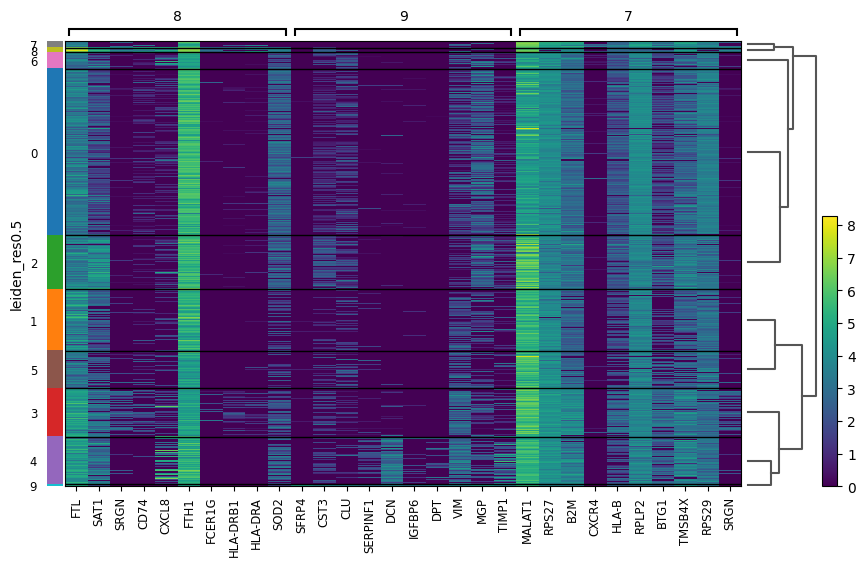

In [105]:
sc.pl.rank_genes_groups_heatmap(new_adata,  groups=["8", "9", "7"], n_genes=10, groupby="leiden_res0.5")

In [122]:
adata_dir = "GSE161529_analysis/"  # Update with your path

adata_files = [os.path.join(adata_dir, f) for f in os.listdir(adata_dir) if f.endswith(".h5ad")]
c=0
# Process each AnnData file
for adata_file in adata_files:
    c+=1
print(c)

69


In [87]:
pip install harmonypy

Note: you may need to restart the kernel to use updated packages.


In [144]:
adata_files

['GSE161529_analysis/GSM4909253_N-PM0092-Total_processed.h5ad',
 'GSE161529_analysis/GSM4909254_N-PM0019-Total_processed.h5ad',
 'GSE161529_analysis/GSM4909255_N-N280-Epi_processed.h5ad',
 'GSE161529_analysis/GSM4909256_N-PM0095-Epi_processed.h5ad',
 'GSE161529_analysis/GSM4909257_N-PM0095-Total_processed.h5ad',
 'GSE161529_analysis/GSM4909258_N-NF-Epi_processed.h5ad',
 'GSE161529_analysis/GSM4909259_N-NE-Epi_processed.h5ad',
 'GSE161529_analysis/GSM4909260_N-N1105-Epi_processed.h5ad',
 'GSE161529_analysis/GSM4909261_N-PM0230-Total_processed.h5ad',
 'GSE161529_analysis/GSM4909262_N-MH0064-Epi_processed.h5ad',
 'GSE161529_analysis/GSM4909263_N-MH0064-Total_processed.h5ad',
 'GSE161529_analysis/GSM4909264_N-N1B-Epi_processed.h5ad',
 'GSE161529_analysis/GSM4909265_N-PM0233-Total_processed.h5ad',
 'GSE161529_analysis/GSM4909266_N-MH0169-Total_processed.h5ad',
 'GSE161529_analysis/GSM4909267_N-MH0023-Epi_processed.h5ad',
 'GSE161529_analysis/GSM4909268_N-MH0023-Total_processed.h5ad',
 'GSE1

    using 'X_pca' with n_pcs = 60
Storing dendrogram info using `.uns['dendrogram_leiden_res0.5']`
categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2


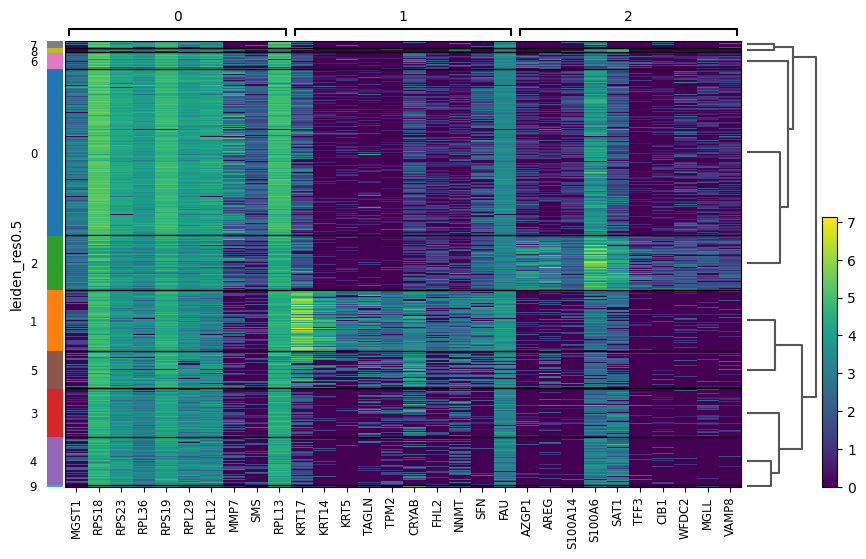

In [109]:
import dask
import dask.array as da
import anndata as ad
from pathlib import Path

# Define paths and parameters
file_paths 
for file in adata_files:
    adata= ad.read_h5ad(file)
    sc.pl.rank_genes_groups_heatmap(adata,  groups=["0", "1", "2"], n_genes=10, groupby="leiden_res0.5")
    break


In [92]:
print("hi")

hi


In [96]:
pip install zarr



  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/834.2 kB ? eta -:--:--
   ------------------------------------- -- 786.4/834.2 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 834.2/834.2 kB 2.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5047 sha256=907e760e8a989072b4e2ecb6e94f7d7798d674353ce7d2eb416c2231947b0dba
  Stored in directory: c:\users\neermita bhattachary\appdata\local\pip\cache\wheels\a5\d7\98\f56ae733748cd0fa577172bda0e73e0b1f1793c98e09b9e458
Successfully built asciitree


In [171]:
import os
import scanpy as sc
import anndata
import numpy as np

def memory_efficient_concat(adata_files, chunk_size=5):
    """
    Concatenate AnnData files in memory-efficient chunks.
    
    Parameters:
    -----------
    adata_files : list
        List of h5ad file paths.
    chunk_size : int, optional
        Number of files to concatenate in each chunk.
    
    Returns:
    --------
    anndata.AnnData
        Concatenated AnnData object.
    """
    if not adata_files:
        raise ValueError("No files to concatenate")
    final_concat = None
    
    for start_idx in range(0, len(adata_files), chunk_size):
        chunk_files = adata_files[start_idx:start_idx + chunk_size]
        
        chunk_adatas = (sc.read_h5ad(file) for file in chunk_files)
        chunk_concat = anndata.concat(chunk_adatas, label="Sample", join="outer")

        del chunk_adatas
        
        # Merge with the final concatenation
        if final_concat is None:
            final_concat = chunk_concat
        else:
            final_concat = anndata.concat([final_concat, chunk_concat], label="Sample", join="outer")
        
        # Explicitly free memory for the current chunk after it is merged
        del chunk_concat
        print(f"Processed {start_idx + chunk_size} out of {len(adata_files)} files")
    
    return final_concat

# List of h5ad files filtered to include only specified samples
adata_dir = 'GSE161529_analysis/'  # Replace with your actual directory path
sample_ids = [
    "GSM4909268", "GSM4909254", "GSM4909279", "GSM4909280", "GSM4909281",
    "GSM4909282", "GSM4909283", "GSM4909284", "GSM4909285", "GSM4909286",
    "GSM4909287", "GSM4909288", "GSM4909289", "GSM4909290", "GSM4909321",
    "GSM4909318", "GSM4909316", "GSM4909314", "GSM4909312", "GSM4909310"
]

# Filter adata_files to include only the specified sample IDs
adata_files = [
    os.path.join(adata_dir, f) for f in os.listdir(adata_dir)
    if f.endswith(".h5ad") and any(sample_id in f for sample_id in sample_ids)
]
print(len(adata_files))

# Concatenate with memory-efficient method
adata_concat = memory_efficient_concat(adata_files, chunk_size=3)

# Save the final concatenated AnnData object
adata_concat.write("final_adata_concat.h5ad")



20


C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: Use

Processed 3 out of 20 files


C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: Use

Processed 6 out of 20 files


C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processed 9 out of 20 files


C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processed 12 out of 20 files


C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processed 15 out of 20 files


C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processed 18 out of 20 files


C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processed 21 out of 20 files


In [2]:
gc.collect()

0

In [1]:
import gc

In [164]:
for x in adata_files:
    adata=sc.read_h5ad(x)
    print(adata.obs["GSM ID"])
    

AAACCTGAGCACACAG-1    GSM4909254
AAACCTGAGGGCTCTC-1    GSM4909254
AAACCTGAGTGCGTGA-1    GSM4909254
AAACCTGAGTGGTCCC-1    GSM4909254
AAACCTGAGTTCCACA-1    GSM4909254
                         ...    
TTTGTCAGTTCCTCCA-1    GSM4909254
TTTGTCATCGTAGGTT-1    GSM4909254
TTTGTCATCGTCTGCT-1    GSM4909254
TTTGTCATCTACTATC-1    GSM4909254
TTTGTCATCTTAGAGC-1    GSM4909254
Name: GSM ID, Length: 6677, dtype: category
Categories (1, object): ['GSM4909254']
AAACCTGAGAACAATC-1    GSM4909268
AAACCTGAGAAGATTC-1    GSM4909268
AAACCTGAGCGATATA-1    GSM4909268
AAACCTGCAACTGGCC-1    GSM4909268
AAACCTGCAAGCGATG-1    GSM4909268
                         ...    
TTTGTCAAGTTCGATC-1    GSM4909268
TTTGTCACAACTGGCC-1    GSM4909268
TTTGTCACAGACGCCT-1    GSM4909268
TTTGTCAGTCTGCAAT-1    GSM4909268
TTTGTCATCCCTCTTT-1    GSM4909268
Name: GSM ID, Length: 7267, dtype: category
Categories (1, object): ['GSM4909268']
AAACCTGAGAGACTAT-1    GSM4909279
AAACCTGAGGGCTCTC-1    GSM4909279
AAACCTGCAATAACGA-1    GSM4909279
AAACCTGCA

In [173]:
adata_concat.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,leiden_res0.25,leiden_res0.5,leiden_res0.75,leiden_res1.0,GSM ID,...,Age,Cells,Disease,Tissue,Tumor Stage,Tumor Grade,Sampling Site,Menopause Status,Subtype,Sample
AAACCTGAGCACACAG-1,3810,20296,250,1.231770,3810,1,1,3,4,GSM4909254,...,21.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN,0
AAACCTGAGGGCTCTC-1,2472,7987,255,3.192688,2472,4,5,5,7,GSM4909254,...,21.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN,0
AAACCTGAGTGCGTGA-1,988,2011,128,6.364993,988,0,0,0,0,GSM4909254,...,21.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN,0
AAACCTGAGTGGTCCC-1,3411,15394,1231,7.996622,3411,0,0,0,0,GSM4909254,...,21.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN,0
AAACCTGAGTTCCACA-1,1676,5286,322,6.091563,1676,0,0,0,1,GSM4909254,...,21.0,Total,Normal,Breast,NaN,NaN,NaN,Pre,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCGATTG-1,956,2292,34,1.483421,956,0,2,1,0,GSM4909321,...,79.0,Lymph Node,Breast Neoplasm,Lymph Node,T2(2A),NaN,Metastatic,NaN,ER+,1
TTTGTCACATGTTCCC-1,965,2283,14,0.613228,965,0,1,2,1,GSM4909321,...,79.0,Lymph Node,Breast Neoplasm,Lymph Node,T2(2A),NaN,Metastatic,NaN,ER+,1
TTTGTCAGTAATTGGA-1,329,604,3,0.496689,329,1,2,1,10,GSM4909321,...,79.0,Lymph Node,Breast Neoplasm,Lymph Node,T2(2A),NaN,Metastatic,NaN,ER+,1
TTTGTCATCATGTCCC-1,824,1954,43,2.200614,824,0,1,2,1,GSM4909321,...,79.0,Lymph Node,Breast Neoplasm,Lymph Node,T2(2A),NaN,Metastatic,NaN,ER+,1


In [175]:
import scanpy.external as sce

In [178]:
adata

AnnData object with n_obs × n_vars = 4854 × 14882
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75', 'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease', 'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site', 'Menopause Status', 'Subtype'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden_res0.25', 'leiden_res0.25_colors', 'leiden_res0.5', 'leiden_res0.5_colors', 'leiden_res0.75', 'leiden_res0.75_colors', 'leiden_res1.0', 'leiden_res1.0_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [177]:
sce.pp.harmony_integrate(adata_concat, 'GSM ID')

2024-12-09 18:35:59,255 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-09 18:36:45,558 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-09 18:36:47,257 - harmonypy - INFO - Iteration 1 of 10
2024-12-09 18:38:57,291 - harmonypy - INFO - Iteration 2 of 10
2024-12-09 18:41:08,438 - harmonypy - INFO - Iteration 3 of 10
2024-12-09 18:43:20,347 - harmonypy - INFO - Iteration 4 of 10
2024-12-09 18:45:31,554 - harmonypy - INFO - Iteration 5 of 10
2024-12-09 18:47:43,322 - harmonypy - INFO - Iteration 6 of 10
2024-12-09 18:49:25,704 - harmonypy - INFO - Iteration 7 of 10
2024-12-09 18:50:45,372 - harmonypy - INFO - Iteration 8 of 10
2024-12-09 18:51:59,353 - harmonypy - INFO - Iteration 9 of 10
2024-12-09 18:53:01,665 - harmonypy - INFO - Iteration 10 of 10
2024-12-09 18:54:03,241 - harmonypy - INFO - Converged after 10 iterations


In [179]:
adata_concat.obsm['X_pca'] = adata_concat.obsm['X_pca_harmony']

In [182]:
adata_concat

AnnData object with n_obs × n_vars = 124440 × 25938
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75', 'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease', 'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site', 'Menopause Status', 'Subtype', 'Sample'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'

In [183]:
adata_list=[]
for x in adata_files:
    adata=sc.read_h5ad(x)
    adata_list.append(adata)


In [185]:
all_var = [adata.var for adata in adata_list]

# Step 2: Concatenate all .var DataFrames
all_var = pd.concat(all_var, join="outer")



In [186]:
all_var

,gene_ids,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,False,23,0.003226,99.677419,23,23,False,0.002372,0.160202,-1.516024
AL669831.5,ENSG00000237491,False,134,0.019355,98.120617,138,134,False,0.018707,0.846895,-0.402439
FAM87B,ENSG00000177757,False,6,0.000842,99.915849,6,6,False,0.000808,0.670892,-0.687856
LINC00115,ENSG00000225880,False,124,0.017812,98.260870,127,124,False,0.022381,1.303103,0.337375
FAM41C,ENSG00000230368,False,79,0.012202,98.892006,87,79,False,0.011321,0.656312,-0.711501
...,...,...,...,...,...,...,...,...,...,...,...
AC007325.4,ENSG00000278817,False,100,0.022044,97.939843,107,100,False,0.109922,2.013848,-0.032139
AC007325.2,ENSG00000277196,False,5,0.001030,99.896992,5,5,False,0.006070,1.857149,-0.650488
AL354822.1,ENSG00000278384,False,4,0.000824,99.917594,4,4,True,0.006622,2.423208,1.583236
AC004556.1,ENSG00000276345,False,3,0.000618,99.938195,3,3,False,0.002532,1.441251,-2.291662


In [184]:
gc.collect()

66

In [187]:
all_var = all_var[~all_var.index.duplicated()]

In [188]:
all_var = all_var.reindex(adata_concat.var_names)

In [189]:
all_var

,gene_ids,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
A1BG,ENSG00000121410,False,593,0.096073,91.683029,685,593,False,0.118212,1.449425,0.574659
A1BG-AS1,ENSG00000268895,False,159,0.023001,97.769986,164,159,False,0.022420,0.509717,-0.949228
A2M,ENSG00000175899,False,1027,0.256101,85.596073,1826,1027,False,0.343830,1.651839,0.816973
A2M-AS1,ENSG00000245105,False,14,0.001964,99.803647,14,14,False,0.002888,1.316804,0.359593
A2ML1,ENSG00000166535,False,6,0.000814,99.918600,6,6,False,0.001539,1.323075,-0.225338
...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,ENSG00000070476,False,190,0.026648,97.335203,190,190,False,0.025334,0.823700,-0.440054
ZYG11A,ENSG00000203995,False,8,0.001122,99.887798,8,8,False,0.001274,0.483077,-0.992430
ZYG11B,ENSG00000162378,False,720,0.119215,89.901823,850,720,False,0.124767,1.469402,0.607056
ZYX,ENSG00000159840,False,2639,0.816410,62.987377,5821,2638,False,0.571500,1.062065,-0.407079


In [190]:
adata_concat.var = all_var

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
adata_concat= sc.read_h5ad("final_adata_concat.h5ad")

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata_concat

AnnData object with n_obs × n_vars = 124440 × 25938
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75', 'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease', 'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site', 'Menopause Status', 'Subtype', 'Sample'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
# adata_final = adata_concat[np.random.choice(adata_concat.shape[0], 100000, replace=False), :]

### Leiden Clustering and Differential Gene Expression

In [7]:
del adata_concat

In [8]:
import gc
gc.collect()

0

In [5]:
adata_final=adata_concat

In [6]:
adata_final

AnnData object with n_obs × n_vars = 124440 × 25938
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75', 'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease', 'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site', 'Menopause Status', 'Subtype', 'Sample'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
import psutil
print(f"Available memory: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Available memory: 7.26 GB


In [10]:
gc.collect()

0

In [11]:
 sc.pp.highly_variable_genes(adata_final, n_top_genes=2000)

In [12]:
sc.pp.neighbors(adata_final, n_neighbors=10, n_pcs=60)

In [13]:
sc.tl.umap(adata_final)

In [14]:
adata_final

AnnData object with n_obs × n_vars = 124440 × 25938
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75', 'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease', 'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site', 'Menopause Status', 'Subtype', 'Sample'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [15]:
sc.tl.leiden(adata_final, resolution=0.5, key_added="res05")

C:\Users\Neermita Bhattachary\AppData\Local\Temp\ipykernel_11188\288404655.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_final, resolution=0.5, key_added="res05")


In [16]:
sc.tl.leiden(adata_final, resolution=0.75, key_added="res075")

In [17]:
gc.collect()

68183

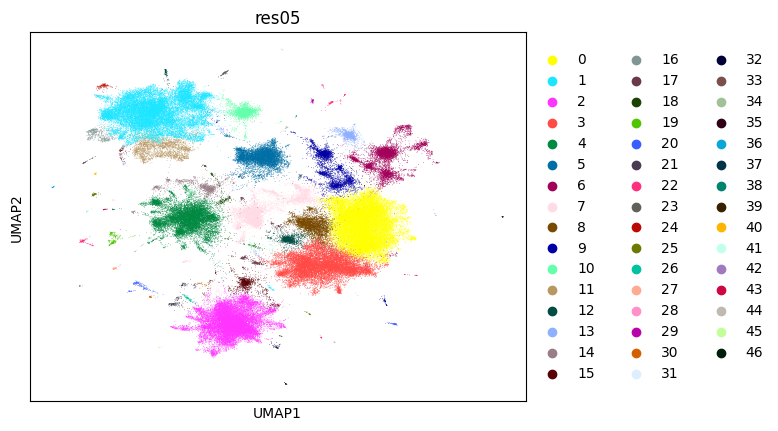

In [32]:
sc.pl.umap(adata_final, color=['res05'])

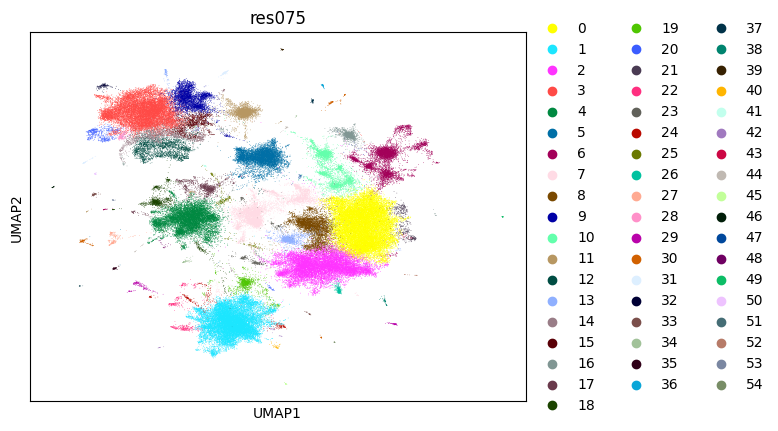

In [19]:
sc.pl.umap(adata_final, color=['res075'])

In [20]:
adata_final

AnnData object with n_obs × n_vars = 124440 × 25938
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75', 'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease', 'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site', 'Menopause Status', 'Subtype', 'Sample', 'res05', 'res075'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'umap', 'hvg', 'res05', 'res075', 'res05_colors', 'res075_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
adata_final.write("finale3.h5ad")

In [24]:
adata_final.obs.columns

Index(['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75',
       'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease',
       'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site',
       'Menopause Status', 'Subtype', 'Sample', 'res05', 'res075'],
      dtype='object')

In [36]:
sc.tl.rank_genes_groups(adata_final, "res05", method="wilcoxon")

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Pyt

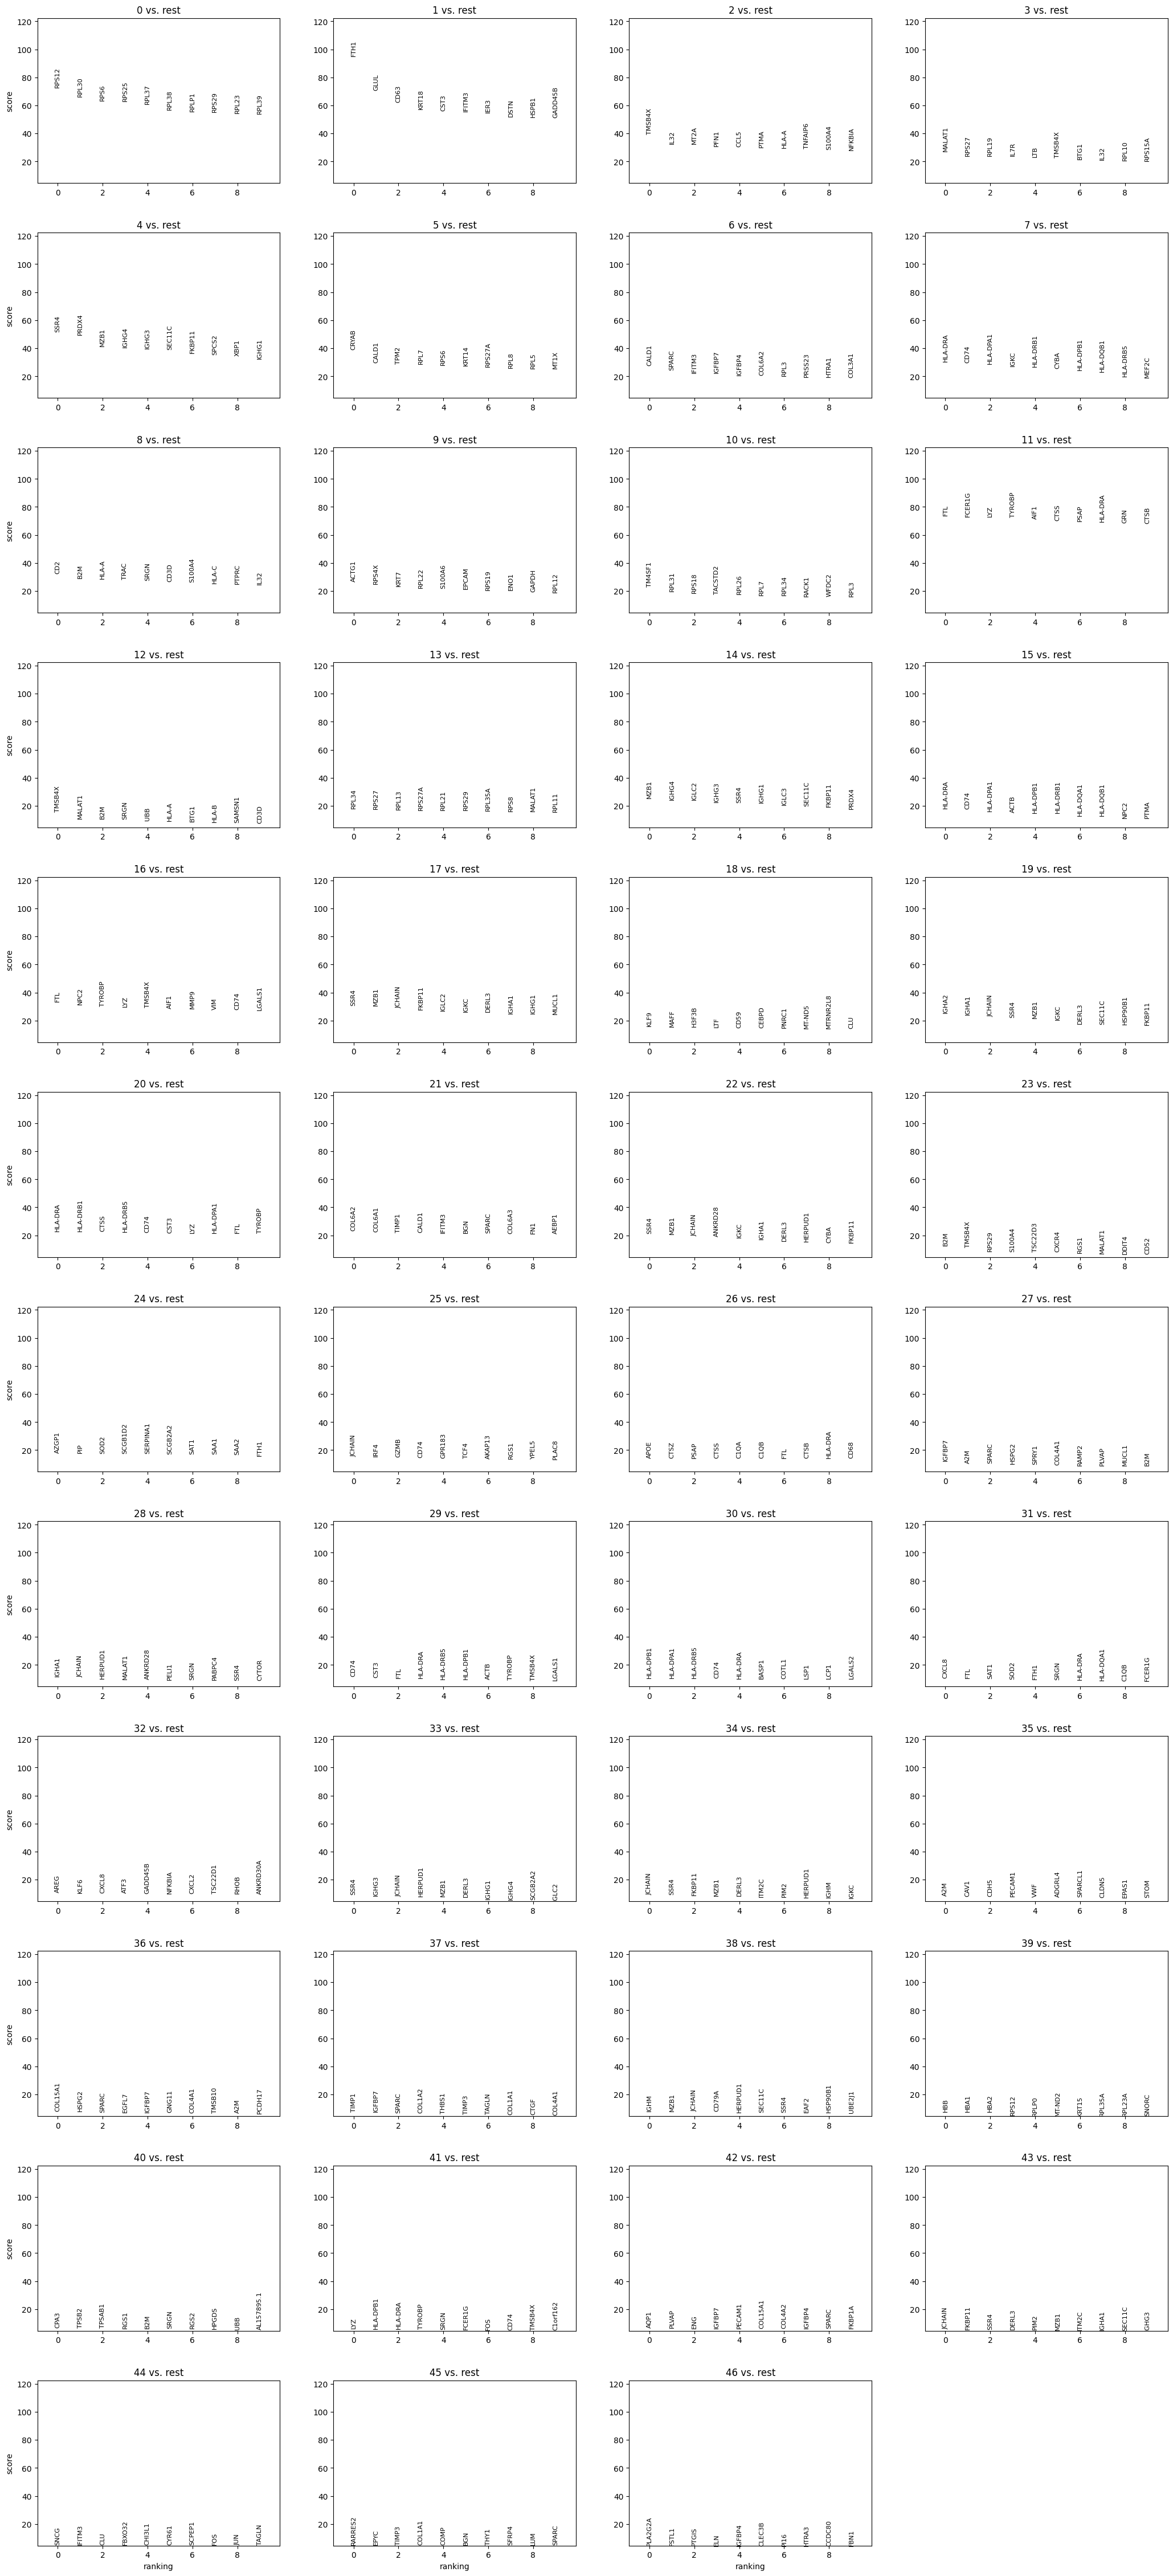

In [37]:
sc.pl.rank_genes_groups(adata_final, n_genes=10)

In [46]:
import matplotlib.pyplot as plt

# Save the currently displayed plot
plt.savefig("rank_genes_groups_plot.png", dpi=300)

<Figure size 640x480 with 0 Axes>

In [38]:
result = adata_final.uns["rank_genes_groups"]
groups= result["names"].dtype.names

In [39]:
groups

('0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46')

In [40]:
cluster_sizes = adata_final.obs['res05'].value_counts()
print(cluster_sizes)

res05
0     22902
1     20330
2     17171
3     15068
4     11043
5      6595
6      5589
7      5283
8      3847
9      3628
10     2490
11     2406
12     1392
13     1346
14     1219
15     1148
16      456
17      395
18      271
19      220
20      214
21      211
22      200
23      153
24      116
25       99
26       79
27       55
28       54
29       51
30       51
31       43
32       42
33       40
34       34
35       25
36       24
37       23
38       23
39       19
40       16
41       15
42       15
43       13
44       10
45        9
46        7
Name: count, dtype: int64


In [41]:
print((adata_final.uns['rank_genes_groups']['names']))

[('RPS12', 'FTH1', 'TMSB4X', 'MALAT1', 'SSR4', 'CRYAB', 'CALD1', 'HLA-DRA', 'CD2', 'ACTG1', 'TM4SF1', 'FTL', 'TMSB4X', 'RPL34', 'MZB1', 'HLA-DRA', 'FTL', 'SSR4', 'KLF9', 'IGHA2', 'HLA-DRA', 'COL6A2', 'SSR4', 'B2M', 'AZGP1', 'JCHAIN', 'APOE', 'IGFBP7', 'IGHA1', 'CD74', 'HLA-DPB1', 'CXCL8', 'AREG', 'SSR4', 'JCHAIN', 'A2M', 'COL15A1', 'TIMP1', 'IGHM', 'HBB', 'CPA3', 'LYZ', 'AQP1', 'JCHAIN', 'SNCG', 'RARRES2', 'PLA2G2A')
 ('RPL30', 'GLUL', 'IL32', 'RPS27', 'PRDX4', 'CALD1', 'SPARC', 'CD74', 'B2M', 'RPS4X', 'RPL31', 'FCER1G', 'MALAT1', 'RPS27', 'IGHG4', 'CD74', 'NPC2', 'MZB1', 'MAFF', 'IGHA1', 'HLA-DRB1', 'COL6A1', 'MZB1', 'TMSB4X', 'PIP', 'IRF4', 'CTSZ', 'A2M', 'JCHAIN', 'CST3', 'HLA-DPA1', 'FTL', 'KLF6', 'IGHG3', 'SSR4', 'CAV1', 'HSPG2', 'IGFBP7', 'MZB1', 'HBA1', 'TPSB2', 'HLA-DPB1', 'PLVAP', 'FKBP11', 'IFITM3', 'EPYC', 'FSTL1')
 ('RPS6', 'CD63', 'MT2A', 'RPL19', 'MZB1', 'TPM2', 'IFITM3', 'HLA-DPA1', 'HLA-A', 'KRT7', 'RPS18', 'LYZ', 'B2M', 'RPL13', 'IGLC2', 'HLA-DPA1', 'TYROBP', 'JCHAIN',

In [43]:
top_features = {}
n_top_genes = 10
for group in groups:
    top_features[group]=result["names"][group][:n_top_genes]
for group, features in top_features.items():
    print(f"Cluster {group} top features")
    for feature in features:
        print(feature)
    print("\n")


Cluster 0 top features
RPS12
RPL30
RPS6
RPS25
RPL37
RPL38
RPLP1
RPS29
RPL23
RPL39


Cluster 1 top features
FTH1
GLUL
CD63
KRT18
CST3
IFITM3
IER3
DSTN
HSPB1
GADD45B


Cluster 2 top features
TMSB4X
IL32
MT2A
PFN1
CCL5
PTMA
HLA-A
TNFAIP6
S100A4
NFKBIA


Cluster 3 top features
MALAT1
RPS27
RPL19
IL7R
LTB
TMSB4X
BTG1
IL32
RPL10
RPS15A


Cluster 4 top features
SSR4
PRDX4
MZB1
IGHG4
IGHG3
SEC11C
FKBP11
SPCS2
XBP1
IGHG1


Cluster 5 top features
CRYAB
CALD1
TPM2
RPL7
RPS6
KRT14
RPS27A
RPL8
RPL5
MT1X


Cluster 6 top features
CALD1
SPARC
IFITM3
IGFBP7
IGFBP4
COL6A2
RPL3
PRSS23
HTRA1
COL3A1


Cluster 7 top features
HLA-DRA
CD74
HLA-DPA1
IGKC
HLA-DRB1
CYBA
HLA-DPB1
HLA-DQB1
HLA-DRB5
MEF2C


Cluster 8 top features
CD2
B2M
HLA-A
TRAC
SRGN
CD3D
S100A4
HLA-C
PTPRC
IL32


Cluster 9 top features
ACTG1
RPS4X
KRT7
RPL22
S100A6
EPCAM
RPS19
ENO1
GAPDH
RPL12


Cluster 10 top features
TM4SF1
RPL31
RPS18
TACSTD2
RPL26
RPL7
RPL34
RACK1
WFDC2
RPL3


Cluster 11 top features
FTL
FCER1G
LYZ
TYROBP
AIF1
CTSS
PSAP
HLA

In [44]:
data= pd.DataFrame({group + "_" + key[:1]: result[key][group] for group in groups for key in ["names", "logfoldchanges", "scores", "pvals"]})
data.to_csv("results.csv")

In [45]:
data

,0_n,0_l,0_s,0_p,1_n,1_l,1_s,1_p,2_n,2_l,...,44_s,44_p,45_n,45_l,45_s,45_p,46_n,46_l,46_s,46_p
0,RPS12,0.648494,73.095779,0.000000e+00,FTH1,1.222194,95.162712,0.0,TMSB4X,0.740586,...,5.372136,7.780939e-08,RARRES2,9.384245,5.194413,2.053673e-07,PLA2G2A,12.189518,4.579082,0.000005
1,RPL30,0.623669,66.567062,0.000000e+00,GLUL,1.571211,71.010735,0.0,IL32,1.069855,...,5.337988,9.398372e-08,EPYC,13.036467,5.194199,2.056030e-07,FSTL1,8.066066,4.577683,0.000005
2,RPS6,0.613926,63.486309,0.000000e+00,CD63,1.022703,62.425850,0.0,MT2A,0.805560,...,5.325998,1.004003e-07,TIMP3,8.073778,5.176503,2.260832e-07,PTGIS,9.523599,4.576179,0.000005
3,RPS25,0.566748,63.273705,0.000000e+00,KRT18,1.450373,57.570591,0.0,PFN1,0.494127,...,5.305860,1.121429e-07,COL1A1,10.223536,5.171650,2.320359e-07,ELN,9.500497,4.574442,0.000005
4,RPL37,0.512028,61.176910,0.000000e+00,CST3,1.121207,56.258938,0.0,CCL5,1.851233,...,5.282364,1.275274e-07,COMP,9.121126,5.170462,2.335157e-07,IGFBP4,7.567685,4.574200,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25933,GADD45B,-1.093011,-34.382931,4.537668e-259,RPS12,-0.371527,-44.111450,0.0,MT-ND4,-0.256802,...,-3.140922,1.684168e-03,MT-ATP6,-3.651806,-3.865128,1.110310e-04,TSTD1,-29.872919,-1.965429,0.049365
25934,CTSB,-1.281665,-35.055431,3.222647e-269,RPL39,-0.322403,-46.546597,0.0,MT-CO1,-0.196795,...,-3.516670,4.369972e-04,MT-ND3,-4.348007,-3.865884,1.106874e-04,RPS7,-0.501839,-2.020595,0.043322
25935,FOS,-0.739626,-35.251575,3.245272e-272,IGKC,-2.251571,-46.570358,0.0,MT-CO3,-0.306749,...,-3.700809,2.149135e-04,MT-CO1,-2.686589,-4.013015,5.994812e-05,FAU,-0.430184,-2.075882,0.037905
25936,SOD2,-1.199445,-35.719051,2.001173e-279,B2M,-0.753805,-51.059647,0.0,MT-CYB,-0.356269,...,-3.918598,8.906538e-05,MT-CO2,-3.268756,-4.022002,5.770554e-05,SPINT2,-30.577145,-2.258862,0.023892


In [53]:
adata_final.write("finale3.h5ad")

### Cell Type Annotation

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
adata_final= sc.read_h5ad("finale3.h5ad")

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
adata_final

AnnData object with n_obs × n_vars = 124440 × 25938
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75', 'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease', 'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site', 'Menopause Status', 'Subtype', 'Sample', 'res05', 'res075'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'neighbors', 'rank_genes_groups', 'res05', 'res05_colors', 'res075', 'res075_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [47]:
pip install decoupler

   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   -- ------------------------------------- 1.0/15.5 MB 5.0 MB/s eta 0:00:03
   --------- ------------------------------ 3.7/15.5 MB 9.9 MB/s eta 0:00:02
   --------------------- ------------------ 8.4/15.5 MB 14.4 MB/s eta 0:00:01
   --------------------------------- ------ 13.1/15.5 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 15.5/15.5 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blis 1.0.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [4]:
import decoupler as dc

In [50]:
pip install omnipath

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19901 sha256=2ce1b6eb8a765c885ecf6c8049b128e32e0fd9dbc7ab9cb5715d1c0e20b3a64c
  Stored in directory: c:\users\neermita bhattachary\appdata\local\pip\cache\wheels\d6\19\ee\0a6a1793d91c449563b49ccab57ce52da3e6fab7614836bd8c
Successfully built docrep
Note: you may need to restart the kernel to use updated packages.


In [5]:
markers = dc.get_resource('PanglaoDB')
markers

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.000000,0.018170,True,0.000000,0.000000,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000


In [6]:
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
6,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.005031,True,0.314286,0.012826,9606,Pancreas,0.013
14,PRSS3,True,Acinar cells,Endoderm,True,0.833333,0.028931,True,0.028571,0.000000,9606,Pancreas,0.006
15,CELA3A,True,Acinar cells,Endoderm,True,0.833333,0.000000,True,0.128571,0.000000,9606,Pancreas,0.001
17,PRSS1,True,Acinar cells,Endoderm,True,1.000000,0.005975,True,0.028571,0.000000,9606,Pancreas,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,TRBC2,True,T cells,Mesoderm,True,0.940711,0.083362,True,0.000000,0.000000,9606,Immune system,0.066
8266,TRAC,True,T cytotoxic cells,Mesoderm,True,1.000000,0.131348,True,0.000000,0.000000,9606,Immune system,0.042
8267,TRAC,True,T cells,Mesoderm,True,0.972332,0.059544,True,0.000000,0.000000,9606,Immune system,0.042
8297,LCK,True,T cells,Mesoderm,True,0.648221,0.033004,True,0.705607,0.030902,9606,Immune system,0.048


In [10]:
dc.run_ora(
    mat=adata_final,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

10 features of mat are empty, they will be removed.
Running ora on mat with 124440 samples and 25928 targets for 50 sources.


  0%|          | 0/124440 [00:00<?, ?it/s]

In [12]:
adata_final.obsm['ora_estimate']

source,Acinar cells,Adipocytes,Alpha cells,Astrocytes,B cells,B cells naive,Basal cells,Beta cells,Cholangiocytes,Clara cells,...,Pancreatic stellate cells,Pericytes,Plasma cells,Plasmacytoid dendritic cells,Platelets,Podocytes,Proximal tubule cells,Pulmonary alveolar type II cells,Smooth muscle cells,T cells
AAACCTGAGCACACAG-1,0.072011,2.105592,-0.000000,-0.000000,0.311030,0.131603,1.918538,-0.000000,3.661981,0.426398,...,0.640000,1.276402,0.425233,0.215398,1.161374,-0.000000,0.181719,0.555324,-0.000000,0.555324
AAACCTGAGGGCTCTC-1,0.072011,0.689036,-0.000000,0.235194,0.311030,0.131603,-0.000000,-0.000000,-0.000000,-0.000000,...,3.852646,1.276402,0.425233,0.215398,0.197668,0.131603,-0.000000,0.555324,-0.000000,0.555324
AAACCTGAGTGCGTGA-1,0.259563,0.689036,-0.000000,0.235194,0.873481,0.131603,1.918538,-0.000000,0.873481,0.426398,...,0.215398,0.479847,0.425233,0.640000,0.595643,0.131603,-0.000000,1.091855,0.689036,0.555324
AAACCTGAGTGGTCCC-1,-0.000000,1.321454,-0.000000,0.235194,-0.000000,0.131603,1.918538,-0.000000,-0.000000,-0.000000,...,0.215398,2.328774,0.131603,0.215398,0.595643,-0.000000,0.181719,0.181719,3.025193,0.555324
AAACCTGAGTTCCACA-1,-0.000000,1.321454,-0.000000,0.235194,-0.000000,-0.000000,0.739417,-0.000000,-0.000000,-0.000000,...,0.215398,0.479847,0.131603,-0.000000,-0.000000,0.131603,0.555324,-0.000000,2.105592,0.555324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCGATTG-1,0.072011,0.689036,-0.000000,-0.000000,0.873481,-0.000000,-0.000000,-0.000000,4.909751,-0.000000,...,-0.000000,-0.000000,1.431338,1.982033,0.595643,0.131603,-0.000000,0.555324,-0.000000,0.181719
TTTGTCACATGTTCCC-1,0.565800,0.689036,-0.000000,-0.000000,1.635678,0.864920,-0.000000,-0.000000,4.909751,0.426398,...,-0.000000,-0.000000,1.431338,1.237543,0.595643,-0.000000,-0.000000,1.091855,-0.000000,0.555324
TTTGTCAGTAATTGGA-1,0.259563,0.235194,0.197668,0.235194,0.873481,-0.000000,-0.000000,0.915185,1.635678,-0.000000,...,-0.000000,-0.000000,0.131603,0.640000,0.197668,-0.000000,0.555324,0.555324,-0.000000,0.555324
TTTGTCATCATGTCCC-1,0.565800,0.235194,-0.000000,-0.000000,0.873481,-0.000000,-0.000000,0.142407,6.319681,-0.000000,...,-0.000000,-0.000000,0.131603,0.640000,1.161374,-0.000000,0.181719,0.555324,-0.000000,1.091855


In [13]:
acts = dc.get_acts(adata_final, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 124440 × 50
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75', 'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease', 'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site', 'Menopause Status', 'Subtype', 'Sample', 'res05', 'res075'
    uns: 'hvg', 'neighbors', 'rank_genes_groups', 'res05', 'res05_colors', 'res075', 'res075_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'ora_estimate', 'ora_pvals'

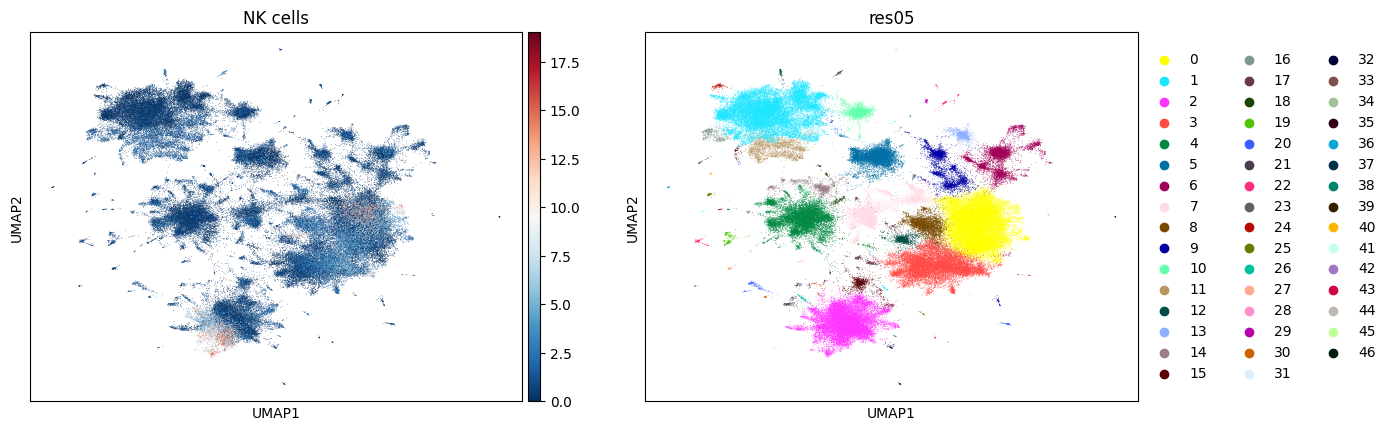

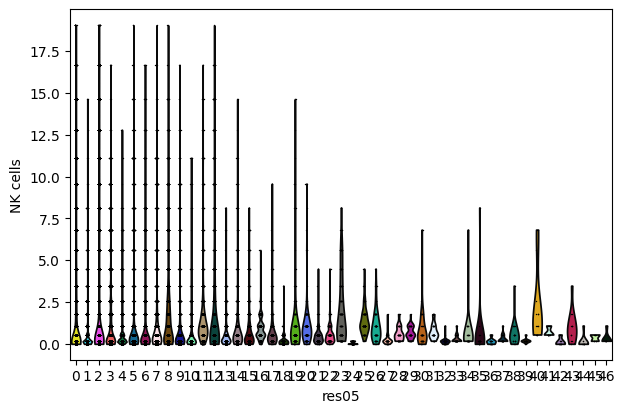

In [15]:
sc.pl.umap(acts, color=['NK cells', 'res05'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['NK cells'], groupby='res05')

In [16]:
df = dc.rank_sources_groups(acts, groupby='res05', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,T cells,32.653365,1.040256,6.256308e-231,5.213590e-230
1,0,rest,NK cells,27.586983,0.697293,5.316994e-166,2.658497e-165
2,0,rest,Gamma delta T cells,25.171008,0.402790,8.791863e-139,2.930621e-138
3,0,rest,Mammary epithelial cells,20.084705,0.347567,2.443048e-89,5.552382e-89
4,0,rest,Germ cells,10.229740,0.056270,1.550617e-24,2.422839e-24
...,...,...,...,...,...,...,...
2345,9,rest,T cells,-9.727692,-0.643169,3.175931e-22,1.443605e-21
2346,9,rest,B cells naive,-10.544507,-0.346791,9.251908e-26,4.625954e-25
2347,9,rest,NK cells,-10.623834,-0.505876,3.895317e-26,2.164065e-25
2348,9,rest,B cells,-10.857511,-0.381136,3.159198e-27,1.974499e-26


In [17]:
df["group"].value_counts()

group
0     50
40    50
32    50
33    50
34    50
35    50
36    50
37    50
38    50
39    50
4     50
41    50
30    50
42    50
43    50
44    50
45    50
46    50
5     50
6     50
7     50
8     50
31    50
3     50
1     50
19    50
10    50
11    50
12    50
13    50
14    50
15    50
16    50
17    50
18    50
2     50
29    50
20    50
21    50
22    50
23    50
24    50
25    50
26    50
27    50
28    50
9     50
Name: count, dtype: int64

In [18]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['T cells', 'NK cells', 'Gamma delta T cells'],
 '1': ['Goblet cells', 'Cholangiocytes', 'Mammary epithelial cells'],
 '10': ['Endothelial cells', 'Luminal epithelial cells', 'Ductal cells'],
 '11': ['Macrophages', 'Dendritic cells', 'Neutrophils'],
 '12': ['T cells', 'NK cells', 'Mast cells'],
 '13': ['Beta cells', 'Delta cells', 'Pulmonary alveolar type II cells'],
 '14': ['Plasma cells', 'Plasmacytoid dendritic cells', 'B cells'],
 '15': ['Dendritic cells', 'B cells', 'B cells naive'],
 '16': ['Neutrophils', 'Dendritic cells', 'Macrophages'],
 '17': ['Plasma cells', 'Plasmacytoid dendritic cells', 'B cells'],
 '18': ['Luminal epithelial cells',
  'Pulmonary alveolar type II cells',
  'Cholangiocytes'],
 '19': ['Plasma cells', 'Plasmacytoid dendritic cells', 'B cells'],
 '2': ['Gamma delta T cells', 'NK cells', 'Loop of Henle cells'],
 '20': ['Dendritic cells', 'Macrophages', 'Neutrophils'],
 '21': ['Hepatic stellate cells', 'Pancreatic stellate cells', 'Fibroblasts'],
 '22': [

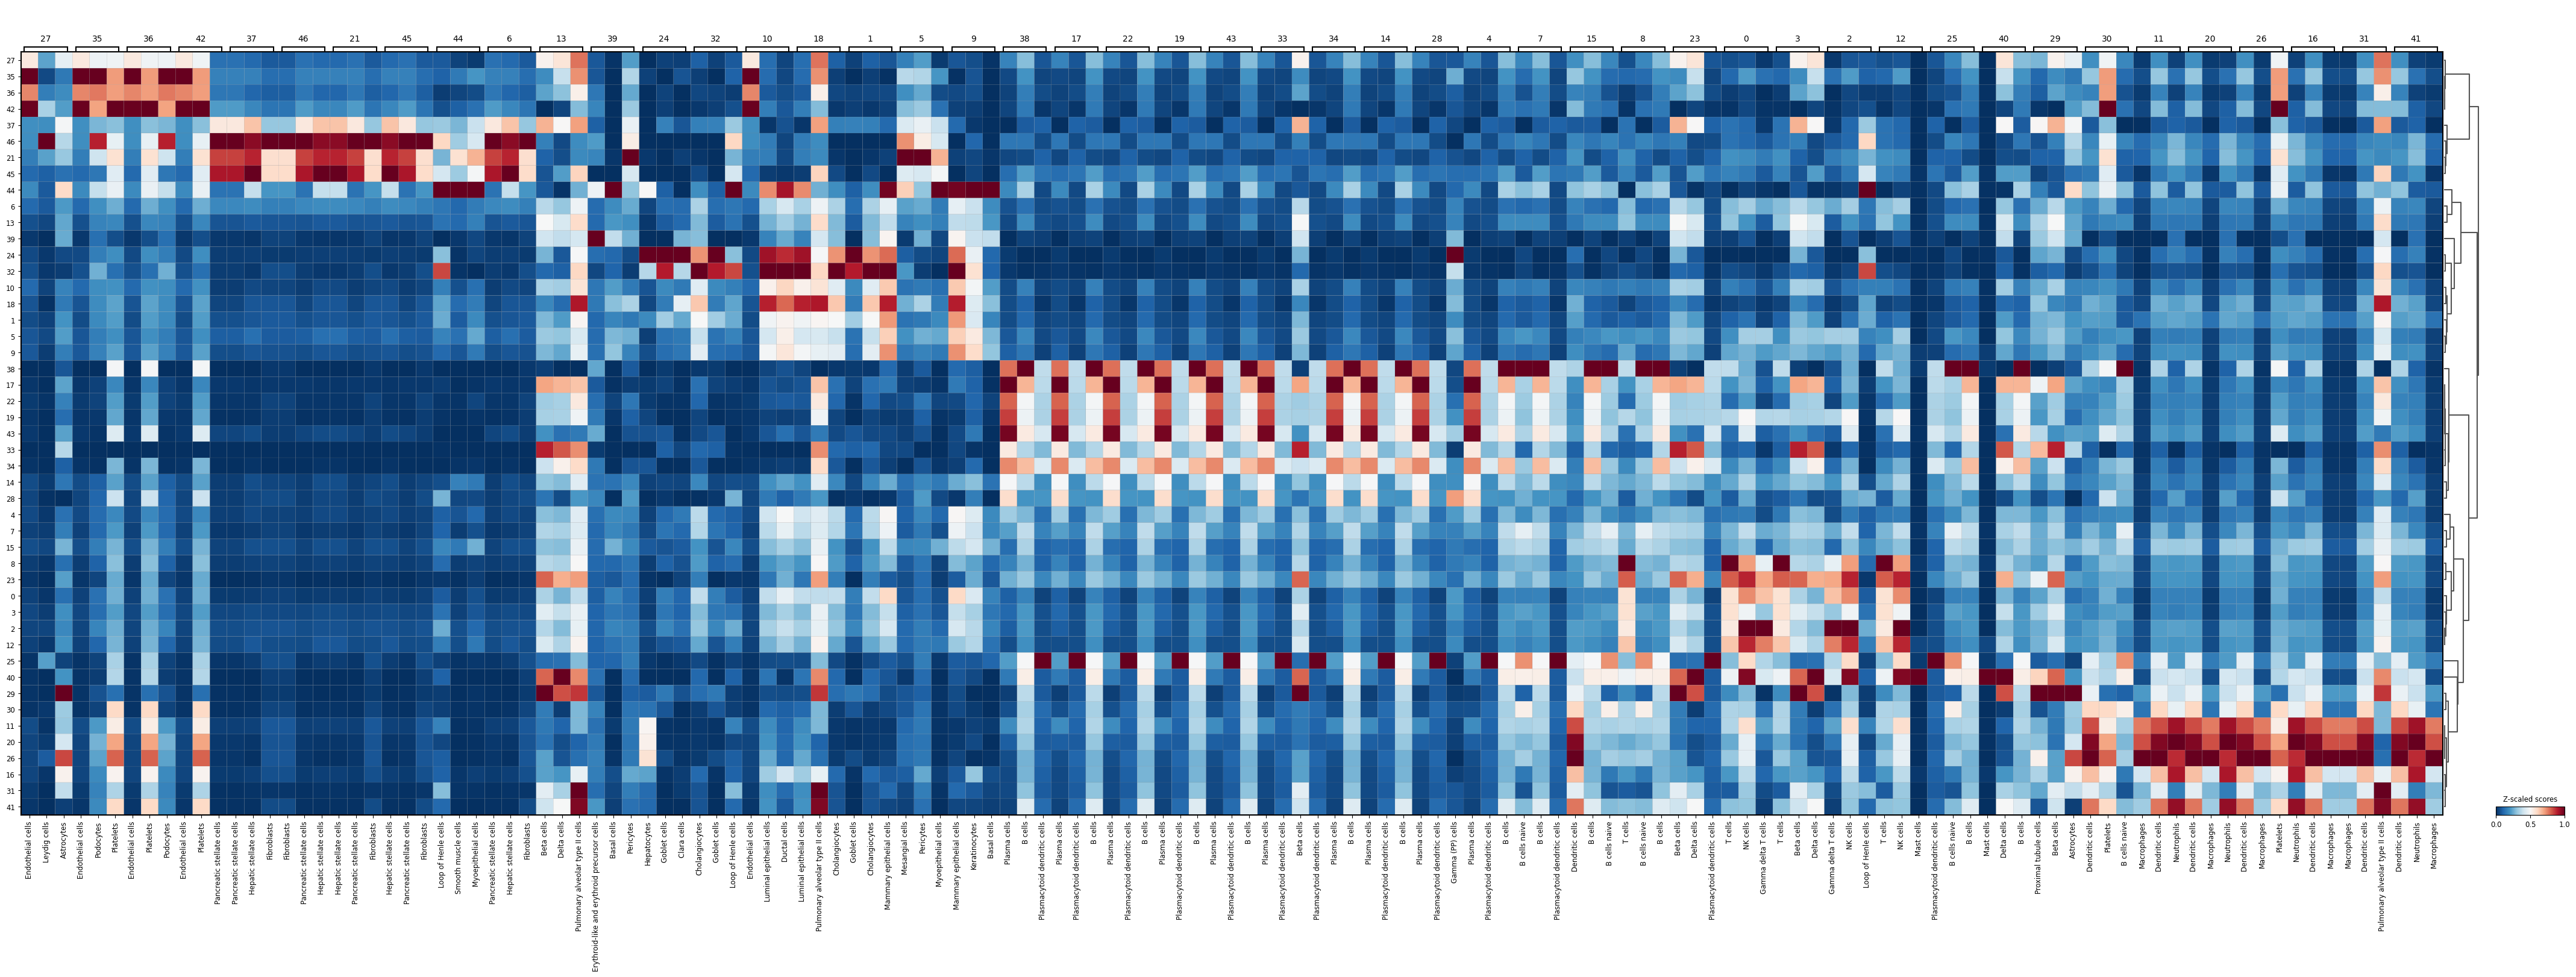

In [19]:
sc.pl.matrixplot(acts, ctypes_dict, 'res05', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

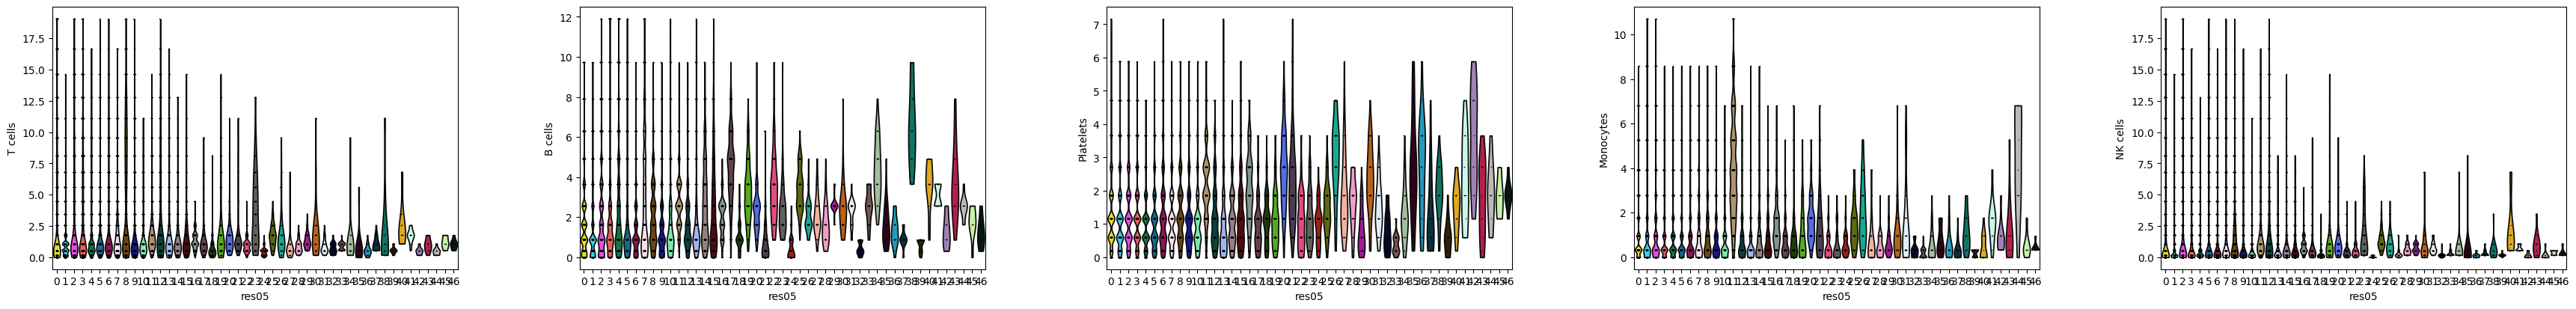

In [21]:
sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='res05')

In [20]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'T cells',
 '1': 'Goblet cells',
 '10': 'Endothelial cells',
 '11': 'Macrophages',
 '12': 'T cells',
 '13': 'Beta cells',
 '14': 'Plasma cells',
 '15': 'Dendritic cells',
 '16': 'Neutrophils',
 '17': 'Plasma cells',
 '18': 'Luminal epithelial cells',
 '19': 'Plasma cells',
 '2': 'Gamma delta T cells',
 '20': 'Dendritic cells',
 '21': 'Hepatic stellate cells',
 '22': 'Plasma cells',
 '23': 'Beta cells',
 '24': 'Hepatocytes',
 '25': 'Plasmacytoid dendritic cells',
 '26': 'Dendritic cells',
 '27': 'Endothelial cells',
 '28': 'Plasma cells',
 '29': 'Proximal tubule cells',
 '3': 'T cells',
 '30': 'Dendritic cells',
 '31': 'Macrophages',
 '32': 'Cholangiocytes',
 '33': 'Plasma cells',
 '34': 'Plasmacytoid dendritic cells',
 '35': 'Endothelial cells',
 '36': 'Endothelial cells',
 '37': 'Pancreatic stellate cells',
 '38': 'Plasma cells',
 '39': 'Erythroid-like and erythroid precursor cells',
 '4': 'Plasma cells',
 '40': 'Mast cells',
 '41': 'Dendritic cells',
 '42': 'Endothelial cells',

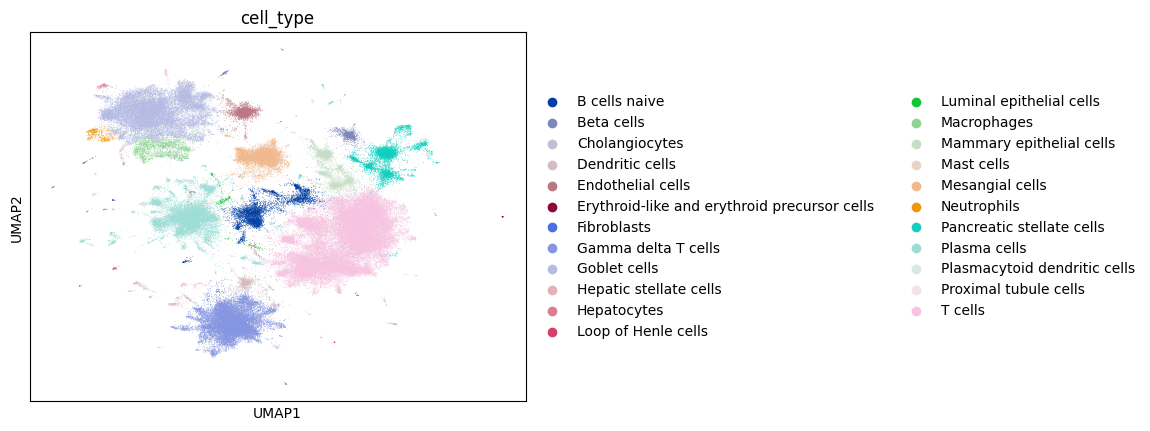

In [23]:
adata_final.obs['cell_type'] = [annotation_dict[clust] for clust in adata_final.obs['res05']]

# Visualize
sc.pl.umap(adata_final, color='cell_type')

In [28]:
adata_final.write("finale3.h5ad")

In [31]:
print(adata_final.raw)

None


In [32]:
adata_final

AnnData object with n_obs × n_vars = 124440 × 25938
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res0.75', 'leiden_res1.0', 'GSM ID', 'Patient ID', 'Age', 'Cells', 'Disease', 'Tissue', 'Tumor Stage', 'Tumor Grade', 'Sampling Site', 'Menopause Status', 'Subtype', 'Sample', 'res05', 'res075', 'cell_type'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'neighbors', 'rank_genes_groups', 'res05', 'res05_colors', 'res075', 'res075_colors', 'umap', 'dendrogram_res05', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'ora_estimate', 'ora_pvals'
    obsp: 'connectivities', 'distances'